# **Feature Engineering**

## Objectives

* We want to select the best feature engineering methods to be used in our pipeline

## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv

## Outputs

* We will have lists of variables and how we should engineer each for the purposes of our pipeline.

## CRISP-DM

* Data preparation 


---

# Change working directory

* The notebooks are stored in a sub folder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues'

# Load Cleaned Data

#### Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1828       0.0           3.0           Av          48          Unf   
1       894       0.0           2.0           No           0          Unf   
2       964       0.0           2.0           No         713          ALQ   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotFrontage  \
0       1774            0.0         774          Unf  ...         90.0   
1        894            0.0         308          Unf  ...         60.0   
2        163            0.0         432          Unf  ...         80.0   

   MasVnrArea OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  \
0       452.0         108            5            9         1822         0.0   
1         0.0           0            5            5          894         0.0   
2         0.0           0            7            5          876         0.0   

   YearBuilt  YearRemodAdd  SalePrice  
0       2007          2007     314813  
1       1962          1962     109500  
2       1921          2006     163500  

[3 rows x 24 columns]

#### Test Set

In [5]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      2515       0.0           4.0           No        1219          Rec   
1       958     620.0           3.0           No         403          BLQ   
2       979     224.0           3.0           No         185          LwQ   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotFrontage  \
0        816            0.0         484          Unf  ...         69.0   
1        238            0.0         240          Unf  ...         79.0   
2        524            0.0         352          Unf  ...         69.0   

   MasVnrArea OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  \
0         0.0           0            3            6         2035         0.0   
1         0.0           0            7            6          806         0.0   
2       161.0           0            4            5          709         0.0   

   YearBuilt  YearRemodAdd  SalePrice  
0       1957          1975     200624  
1       1941          1950     133000  
2       1950          1950     110000  

[3 rows x 24 columns]

# Data Exploration

In [6]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

* We see from this report that a number of our variable have skewed distributions. We will attempt to normalise some of these distributions with Numerical Transformations
* There are ome variables with outliers, we may use Winorizer of Outlier trimmer to handle these anomalies in the data
* We will use Categorical Variable Encoding on our categorical varaibles in order to convert them to integers, which our model will be able to handle 

# Correlation and PPS analysis

* We will run a correlation and power predictive score analysis to investigate the correlation levels between variables in our TrainSet
    * Custom functions used are taken & adapted from *CI Walkthrough Project: Churnometer Data Cleaning notebook*

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import ppscore as pps

def heatmap_corr(df,threshold, figsize=(20,12), font_annot = 8):
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
    plt.show()


def heatmap_pps(df,threshold, figsize=(20,12), font_annot = 8):
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=np.bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True,yticklabels=True,
                       mask=mask,cmap='rocket_r', annot_kws={"size": font_annot},
                       linewidth=0.05,linecolor='grey')
      
      plt.ylim(len(df.columns),0)
      plt.show()



def CalculateCorrAndPPS(df):
  df_corr_spearman = df.corr(method="spearman")
  df_corr_pearson = df.corr(method="pearson")

  pps_matrix_raw = pps.matrix(df)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix,CorrThreshold,PPS_Threshold,
                      figsize=(20,12), font_annot=8 ):

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Power Predictive Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(TrainSet)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.049  0.099  0.0  0.0  0.0  0.054  0.616


* The most common PPS scores are between 0 and 0.75
* We now plot heatmaps in order to check levels of correlation between variables



*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



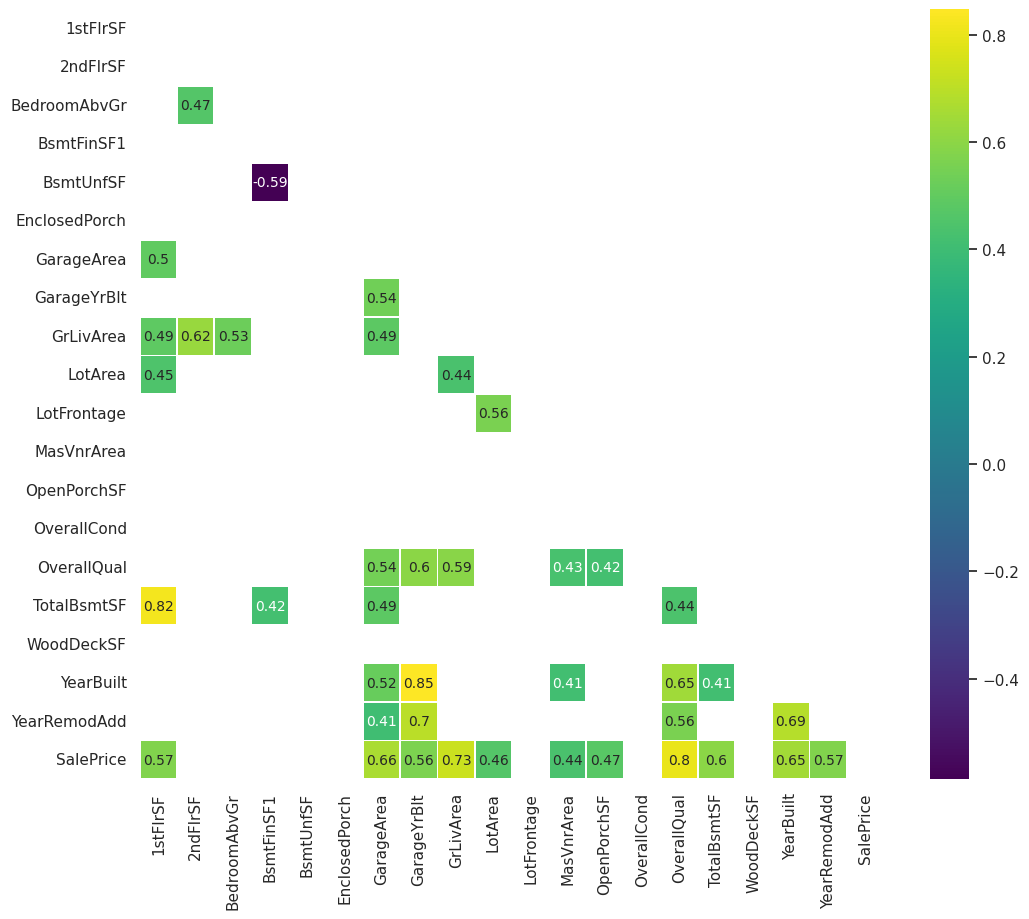



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



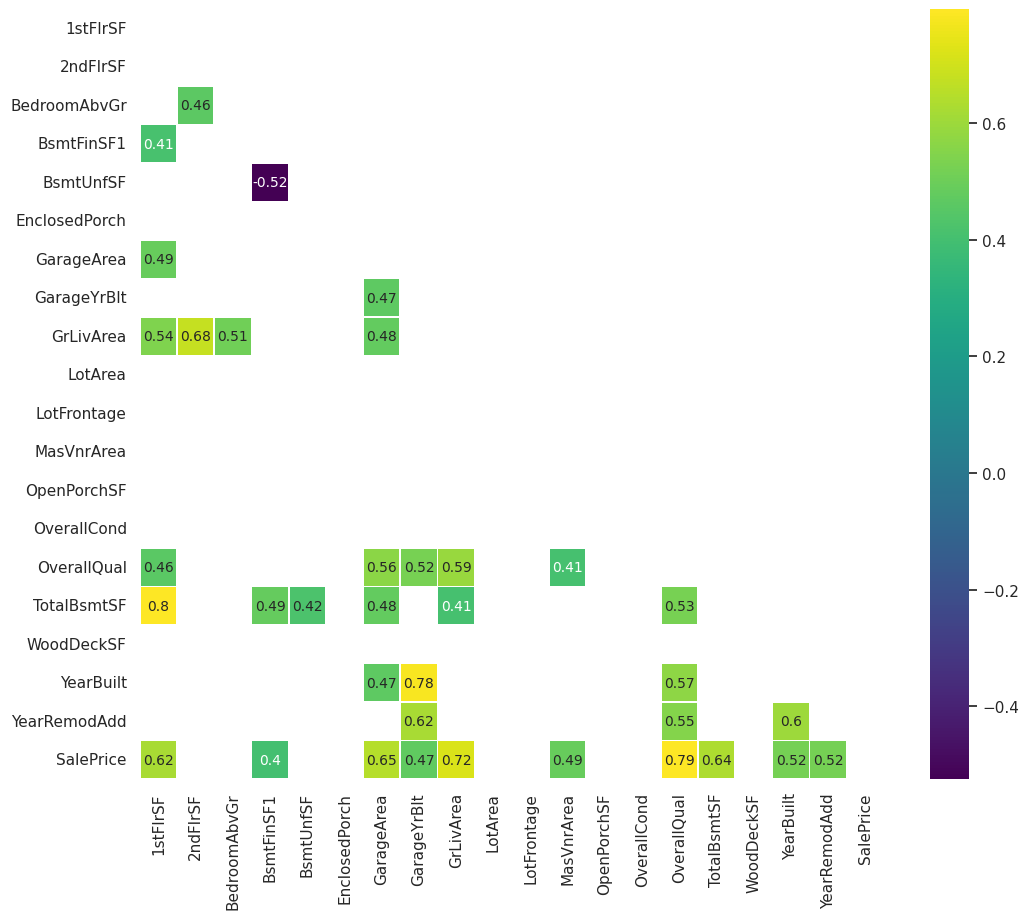



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



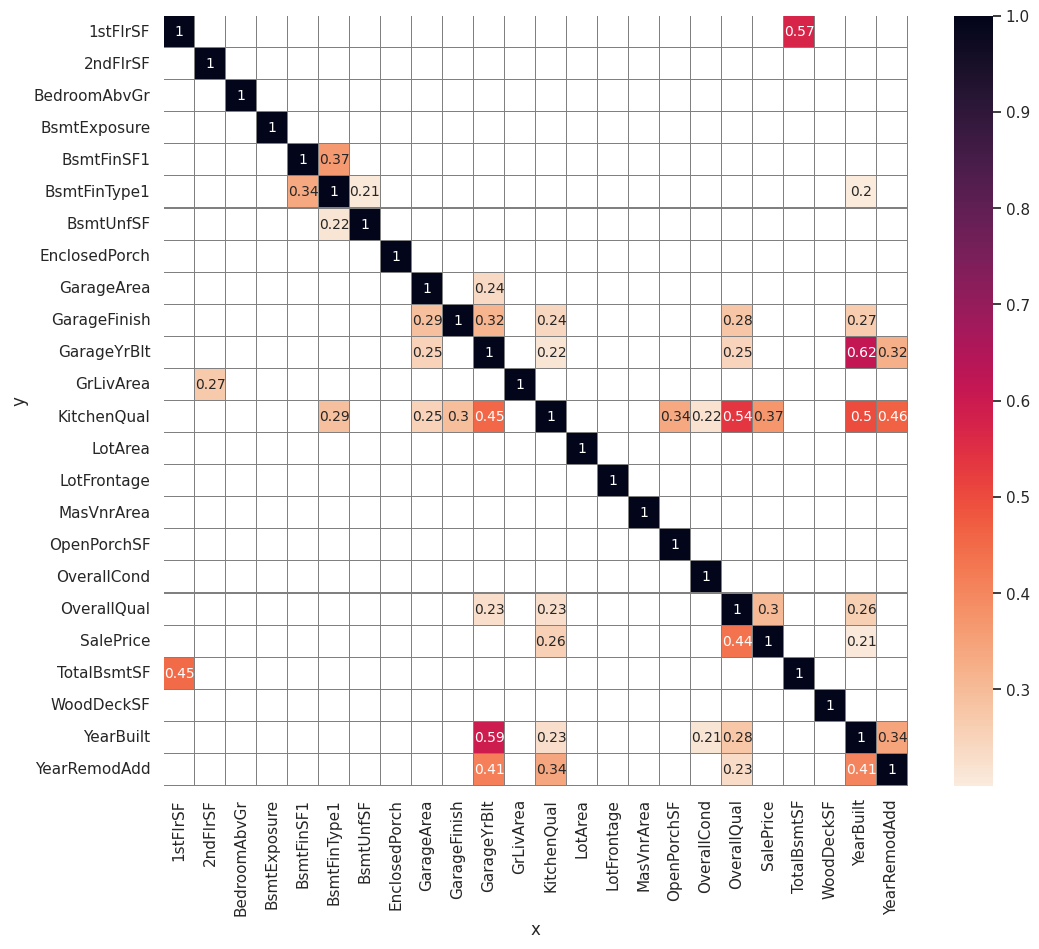

In [8]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

* We note there is a relatively high correlation bewteen SalesPrice and a number of variables
* For PPS, we note that only 'KitchenQual' & 'OverallQual' have relatively high predictive power for 'SalesPrice', whereas a number of other variables have high PPS between themselves.
* It seems that it will be necessary to remove some surplus correlated features in order to not overfit the model. We will use SmartCorrelatedSelection to handle this.

# Feature Engineering

* As stated above, during our data exploration, we will look at the following techniques to transform our data:
    1. Numerical Transformation
    2. Handle outliers
    3. Categorical Encoding
    4. Smart Correlated Selection


* The below functions will help with our feture engineering analysis and allow us to choose how to proceed
    * Custom functions taken from CI lesson: *Feature Engine Unit 9: Custom Functions*

In [9]:
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
import scipy.stats as stats
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')



def FeatureEngineeringAnalysis(df,analysis_type=None):


  """
  - used for quick feature engineering on numerical and categorical variables
  to decide which transformation can better transform the distribution shape 
  - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions

  """
  check_missing_values(df)
  allowed_types= ['numerical', 'ordinal_encoder',  'outlier_winsorizer']
  check_user_entry_on_analysis_type(analysis_type, allowed_types)
  list_column_transformers = define_list_column_transformers(analysis_type)
  
  
  # Loop over each variable and engineer the data according to the analysis type
  df_feat_eng = pd.DataFrame([])
  for column in df.columns:
    # create additional columns (column_method) to apply the methods
    df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
    for method in list_column_transformers:
      df_feat_eng[f"{column}_{method}"] = df[column]
      
    # Apply transformers in respectives column_transformers
    df_feat_eng, list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)

    # For each variable, assess how the transformations perform
    transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)

  return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
  ### Check analyis type
  if analysis_type == None:
    raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
  if analysis_type not in allowed_types:
      raise SystemExit(f"analysis_type argument should be one of these options: {allowed_types}")

def check_missing_values(df):
  if df.isna().sum().sum() != 0:
    raise SystemExit(
        f"There is missing values in your dataset. Please handle that before getting into feature engineering.")



def define_list_column_transformers(analysis_type):
  ### Set suffix colummns acording to analysis_type
  if analysis_type=='numerical':
    list_column_transformers = ["log_e","log_10","reciprocal", "power","box_cox","yeo_johnson"]
  
  elif analysis_type=='ordinal_encoder':
    list_column_transformers = ["ordinal_encoder"]

  elif analysis_type=='outlier_winsorizer':
    list_column_transformers = ['iqr']

  return list_column_transformers



def apply_transformers(analysis_type, df_feat_eng, column):


  for col in df_feat_eng.select_dtypes(include='category').columns:
    df_feat_eng[col] = df_feat_eng[col].astype('object')


  if analysis_type=='numerical':
    df_feat_eng,list_applied_transformers = FeatEngineering_Numerical(df_feat_eng,column)
  
  elif analysis_type=='outlier_winsorizer':
    df_feat_eng,list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng,column)

  elif analysis_type=='ordinal_encoder':
    df_feat_eng,list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng,column)

  return df_feat_eng,list_applied_transformers



def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
  # For each variable, assess how the transformations perform
  print(f"* Variable Analyzed: {column}")
  print(f"* Applied transformation: {list_applied_transformers} \n")
 
  for col in [column] + list_applied_transformers:
    
    if analysis_type!='ordinal_encoder':
      DiagnosticPlots_Numerical(df_feat_eng, col)

    
    else:
      if col == column: 
        DiagnosticPlots_Categories(df_feat_eng, col)
      else:
        DiagnosticPlots_Numerical(df_feat_eng, col)

    print("\n")



def DiagnosticPlots_Categories(df_feat_eng, col):
  plt.figure(figsize=(20, 5))
  sns.countplot(data=df_feat_eng, x=col,palette=['#432371'],order = df_feat_eng[col].value_counts().index)
  plt.xticks(rotation=90) 
  plt.suptitle(f"{col}", fontsize=30,y=1.05)        
  plt.show();
  print("\n")



def DiagnosticPlots_Numerical(df, variable):
  fig, axes = plt.subplots(1, 3, figsize=(20, 6))
  sns.histplot(data=df, x=variable, kde=True,element="step",ax=axes[0]) 
  stats.probplot(df[variable], dist="norm", plot=axes[1])
  sns.boxplot(x=df[variable],ax=axes[2])
  
  axes[0].set_title('Histogram')
  axes[1].set_title('QQ Plot')
  axes[2].set_title('Boxplot')
  fig.suptitle(f"{variable}", fontsize=30,y=1.05)
  plt.show();


def FeatEngineering_CategoricalEncoder(df_feat_eng,column):
  list_methods_worked = []
  try:  
    encoder= OrdinalEncoder(encoding_method='arbitrary', variables = [f"{column}_ordinal_encoder"])
    df_feat_eng = encoder.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_ordinal_encoder")
  
  except: 
    df_feat_eng.drop([f"{column}_ordinal_encoder"],axis=1,inplace=True)
    
  return df_feat_eng,list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng,column):
  list_methods_worked = []

  ### Winsorizer iqr
  try: 
    disc=Winsorizer(
        capping_method='iqr', tail='both', fold=1.5, variables = [f"{column}_iqr"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_iqr")
  except: 
    df_feat_eng.drop([f"{column}_iqr"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked




def FeatEngineering_Numerical(df_feat_eng,column):

  list_methods_worked = []

  ### LogTransformer base e
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_e"])
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_e")
  except: 
    df_feat_eng.drop([f"{column}_log_e"],axis=1,inplace=True)

    ### LogTransformer base 10
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_10"],base='10')
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_10")
  except: 
    df_feat_eng.drop([f"{column}_log_10"],axis=1,inplace=True)

  ### ReciprocalTransformer
  try:
    rt = vt.ReciprocalTransformer(variables = [f"{column}_reciprocal"])
    df_feat_eng =  rt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_reciprocal")
  except:
    df_feat_eng.drop([f"{column}_reciprocal"],axis=1,inplace=True)

  ### PowerTransformer
  try:
    pt = vt.PowerTransformer(variables = [f"{column}_power"])
    df_feat_eng = pt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_power")
  except:
    df_feat_eng.drop([f"{column}_power"],axis=1,inplace=True)

  ### BoxCoxTransformer
  try:
    bct = vt.BoxCoxTransformer(variables = [f"{column}_box_cox"])
    df_feat_eng = bct.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_box_cox")
  except:
    df_feat_eng.drop([f"{column}_box_cox"],axis=1,inplace=True)


  ### YeoJohnsonTransformer
  try:
    yjt = vt.YeoJohnsonTransformer(variables = [f"{column}_yeo_johnson"])
    df_feat_eng = yjt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_yeo_johnson")
  except:
        df_feat_eng.drop([f"{column}_yeo_johnson"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked

## Categorical Encoding
* We select variables

In [10]:
categorical_encoding_vars =TrainSet.select_dtypes(include=['object']).columns.to_list()
categorical_encoding_vars

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

* We create a separate data frame with the variables

In [11]:
df_engineered = TrainSet[categorical_encoding_vars].copy()
df_engineered.head(3)

BsmtExposure BsmtFinType1 GarageFinish KitchenQual
0           Av          Unf          Unf          Gd
1           No          Unf          Unf          TA
2           No          ALQ          Unf          TA

* We create our engineered variables and assess the distribution & values.
* In this case, we will try ordinal encoding

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



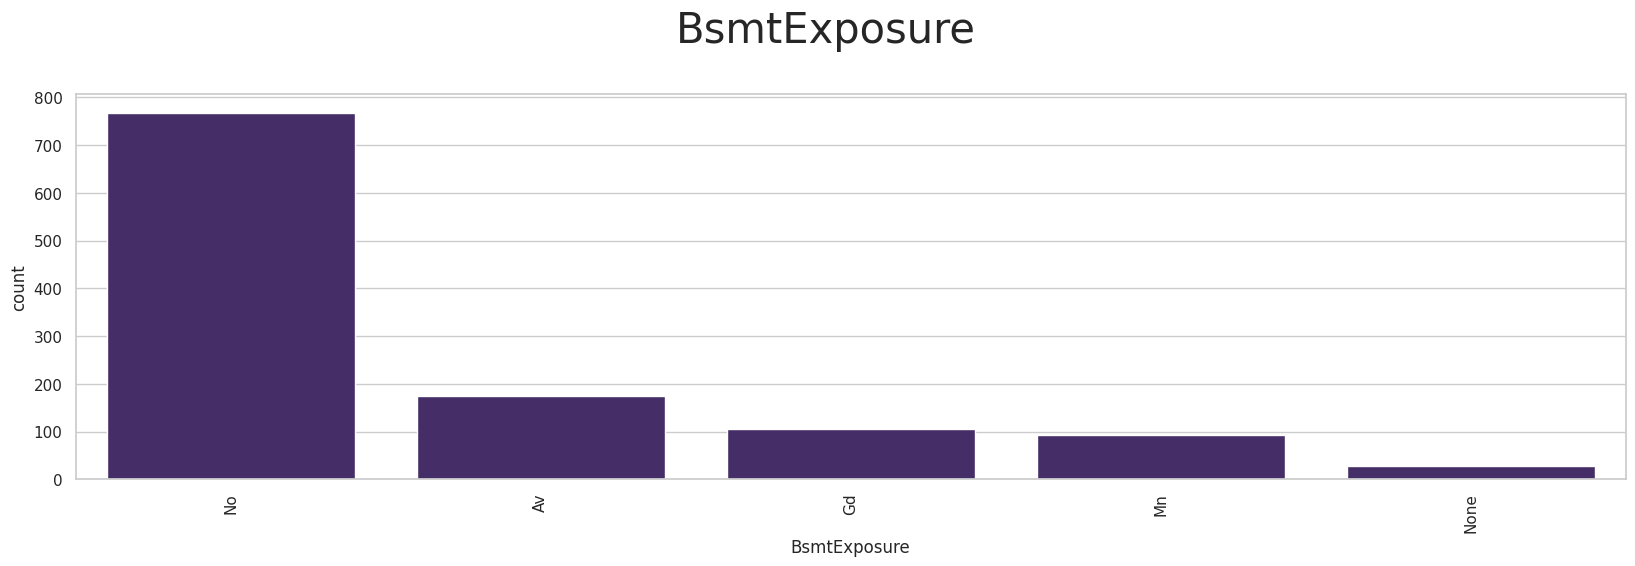

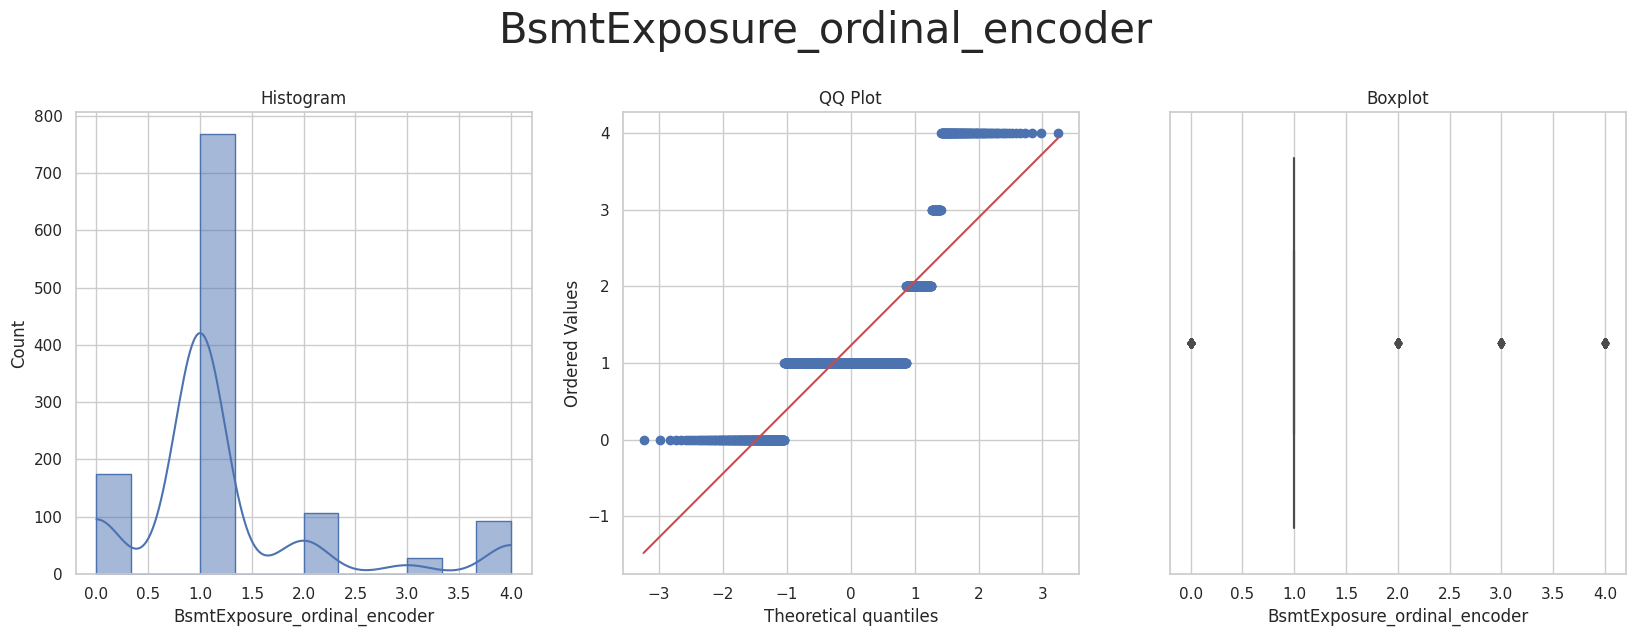



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



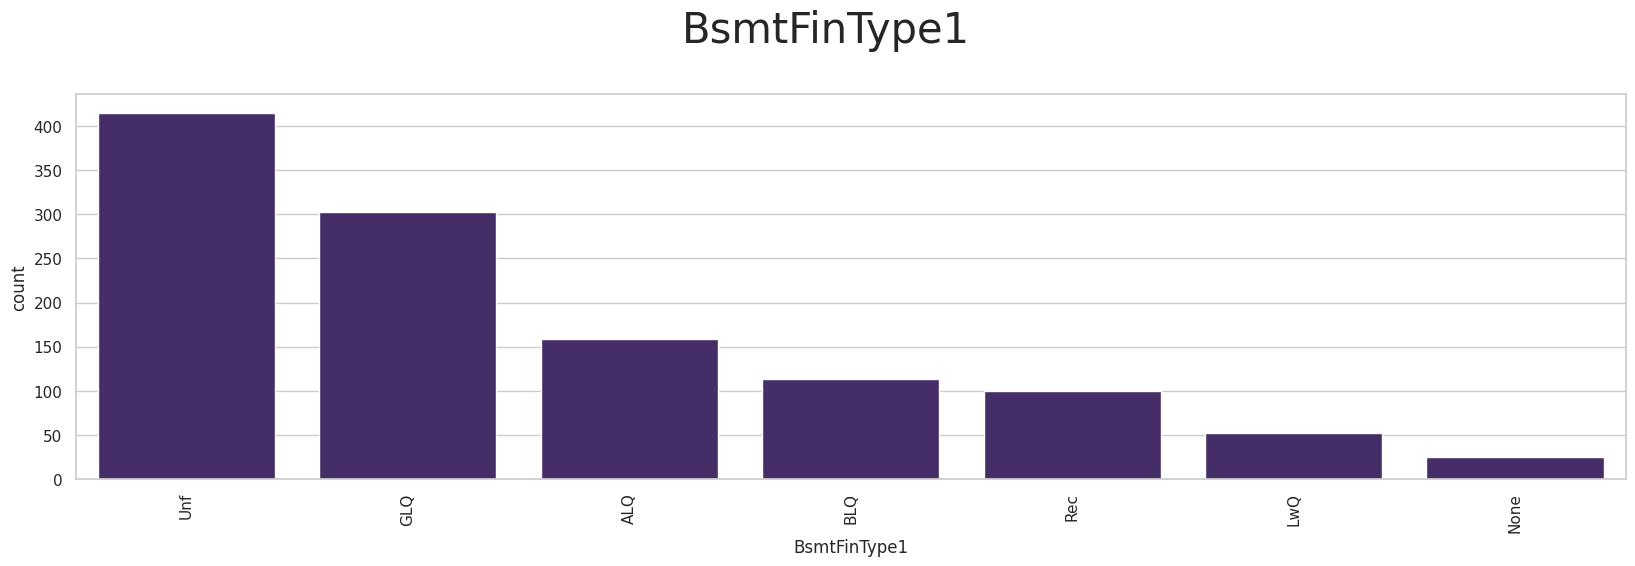

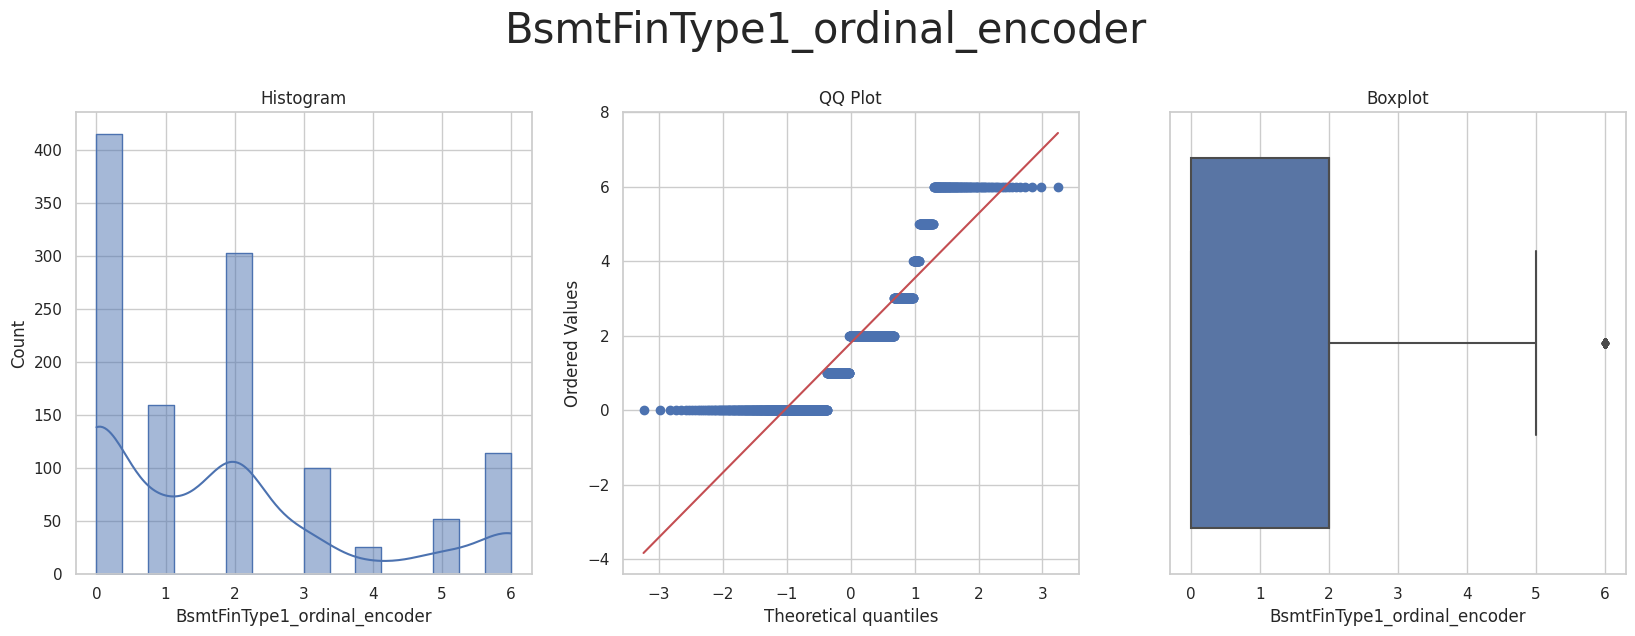



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



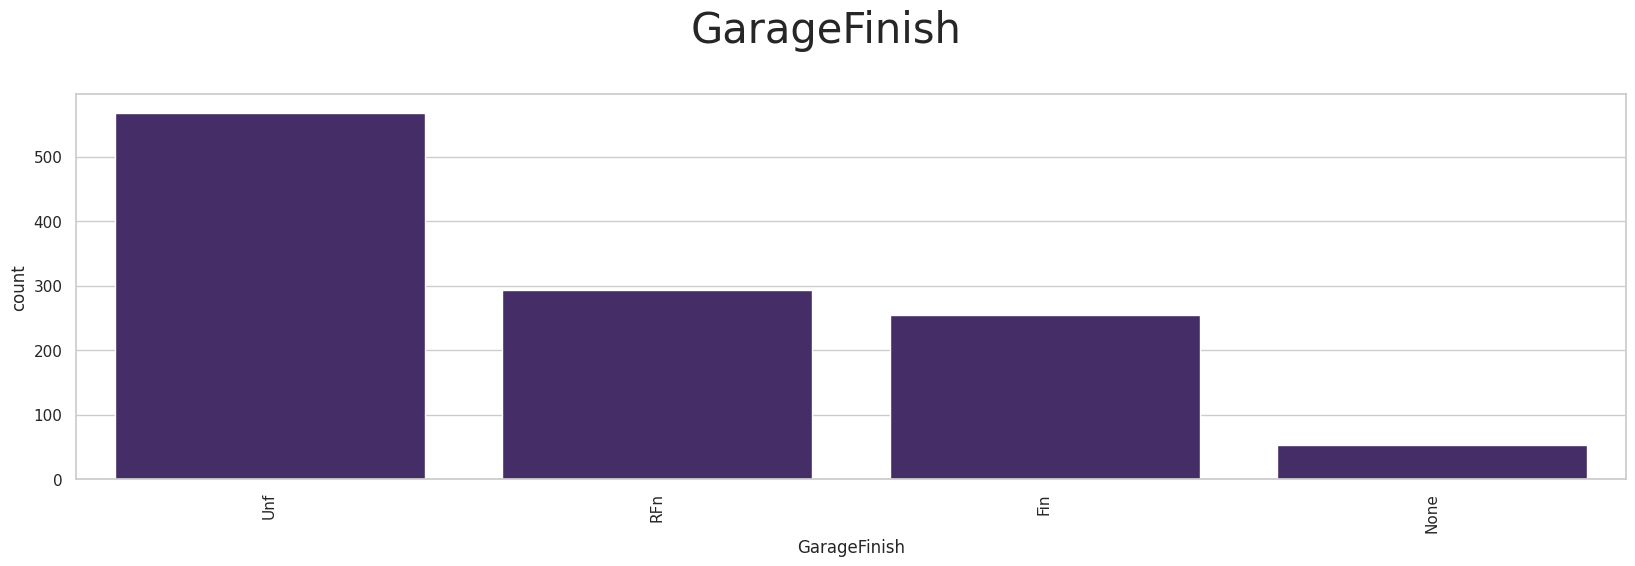

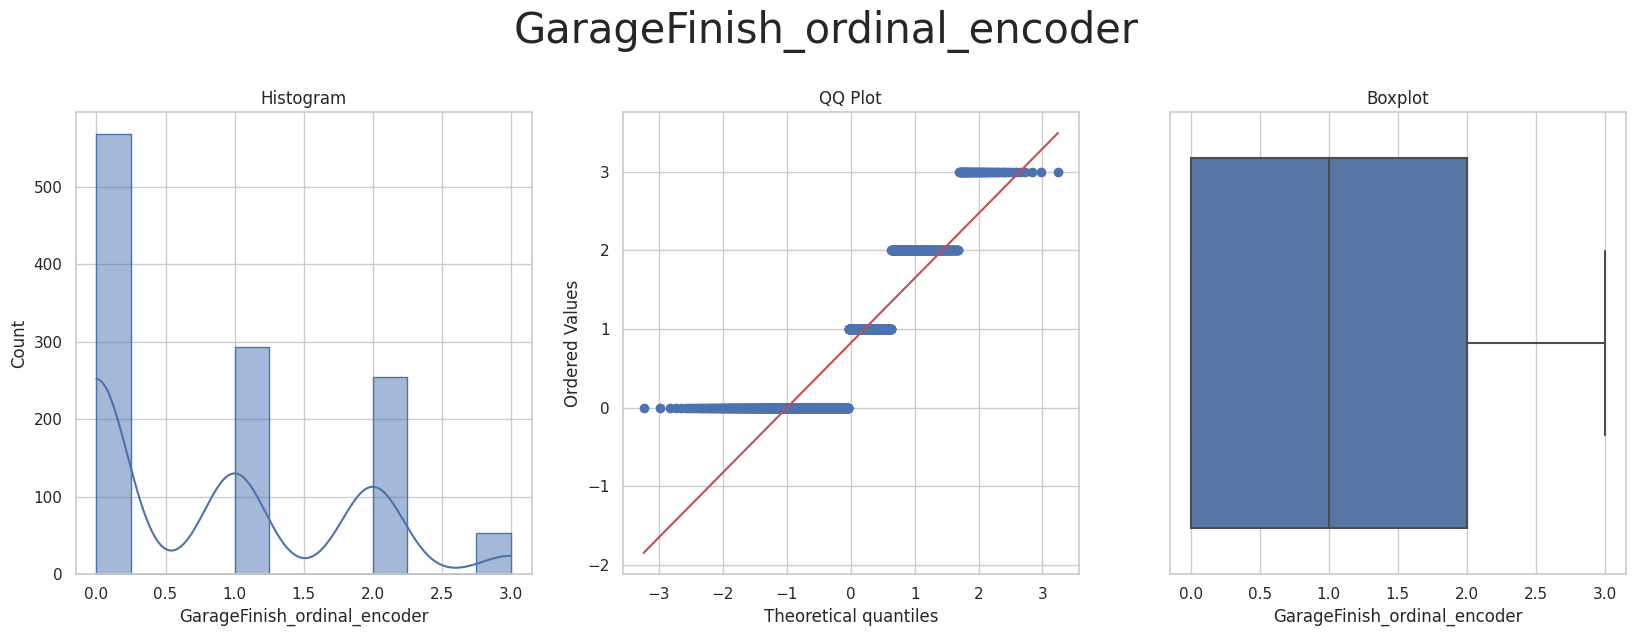



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



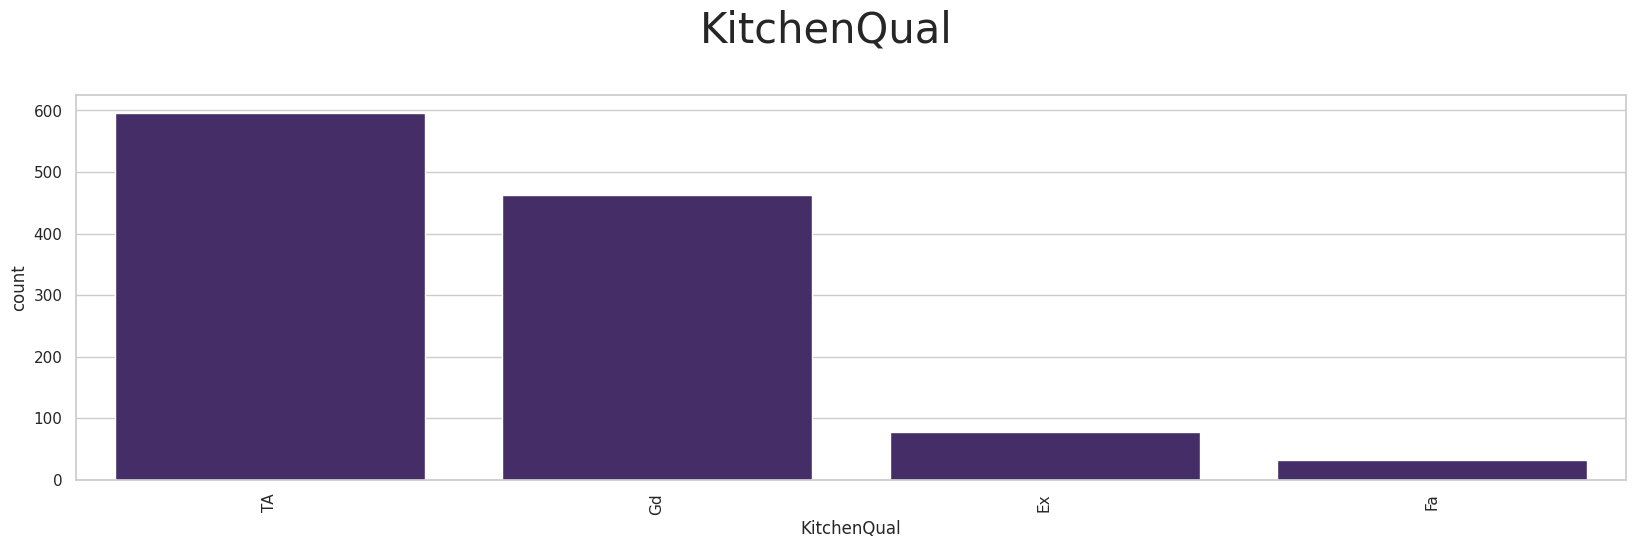

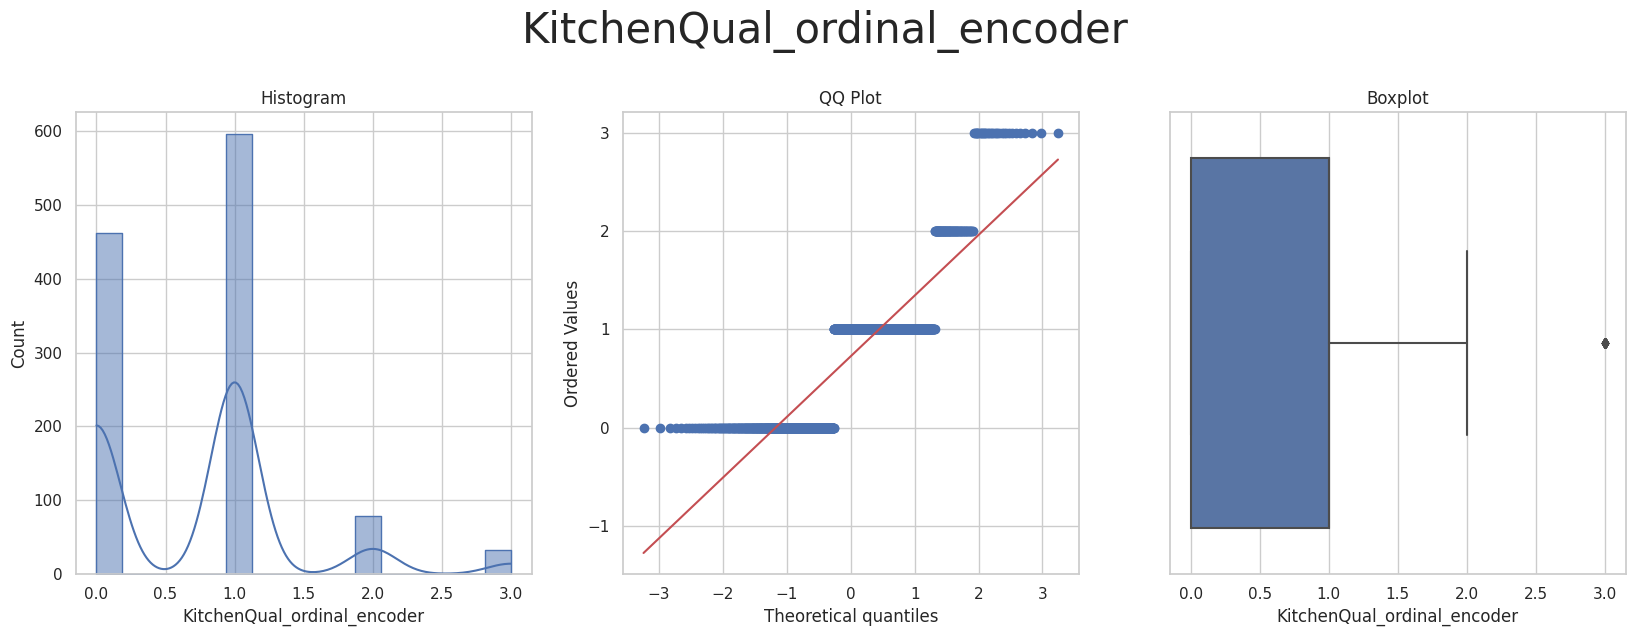

In [12]:
df_engineered = FeatureEngineeringAnalysis(df=df_engineered, analysis_type='ordinal_encoder')

* With this transformation, the distribution does not change for any of the variable.
* We can consider this a successful transformation as the categories have all changed to integers.
* We will apply this transformation, as is, as part of our feature engineering. 

In [13]:
enc = OrdinalEncoder(encoding_method='arbitrary', variables = categorical_encoding_vars)
TrainSet = enc.fit_transform(TrainSet)
TestSet = enc.transform(TestSet)

* We confirm the transformations on TrainSet & TestSet

In [14]:
TrainSet.filter(categorical_encoding_vars).head(3)

BsmtExposure  BsmtFinType1  GarageFinish  KitchenQual
0             0             0             0            0
1             1             0             0            1
2             1             1             0            1

In [15]:
TestSet.filter(categorical_encoding_vars).head(3)

BsmtExposure  BsmtFinType1  GarageFinish  KitchenQual
0             1             3             0            1
1             1             6             0            3
2             1             5             0            0

# Numerical transformation

* We select the variables

In [16]:
numerical_transformation_vars =TrainSet.select_dtypes(include=['float', 'int']).columns.to_list()
numerical_transformation_vars.remove('SalePrice')
numerical_transformation_vars

['1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinType1',
 'BsmtUnfSF',
 'EnclosedPorch',
 'GarageArea',
 'GarageFinish',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd']

* We create a separate DataFrame with the variables

In [17]:
df_engineered = TrainSet[numerical_transformation_vars].copy()
df_engineered.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0      1828       0.0           3.0             0          48             0   
1       894       0.0           2.0             1           0             0   
2       964       0.0           2.0             1         713             1   

   BsmtUnfSF  EnclosedPorch  GarageArea  GarageFinish  ...  LotArea  \
0       1774            0.0         774             0  ...    11694   
1        894            0.0         308             0  ...     6600   
2        163            0.0         432             0  ...    13360   

   LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0         90.0       452.0          108            5            9   
1         60.0         0.0            0            5            5   
2         80.0         0.0            0            7            5   

   TotalBsmtSF  WoodDeckSF  YearBuilt  YearRemodAdd  
0         1822         0.0       2007          2007  
1          894         0.0       1962          1962  
2          876         0.0       1921          2006  

[3 rows x 23 columns]

* We create our engineered variables and assess the distribution & values.

In [18]:
# %matplotlib inline
# df_engineered = FeatureEngineeringAnalysis(df=df_engineered, analysis_type='numerical')

Upon analysis of the numerical transformtions, we will take the following actions:
* For the following variables ;'2ndFlrSF', 'BedroomAbvGr', 'BsmtUnfSF', 'GarageArea', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'YearBuilt' & 'YearRemodAdd', the numerical transformations did not have any significant effect on the distributions. We will therefore not apply any transformations to these variables.
* For '1stFlrSF' & 'LotArea', log_e seems to have the most positive effect on distribution and weill apply it to these variables.
* For 'GrLivArea', yeo johnson shows the most positive effect on our distribution and we will apply it here.

In [19]:
log_transformation_vars = ['1stFlrSF', 'LotArea']
log_transformation_vars

['1stFlrSF', 'LotArea']

In [20]:
from feature_engine import transformation as vt

tf = vt.LogTransformer(variables = log_transformation_vars)
TrainfSet = tf.fit_transform(TrainSet)
TestSet = tf.transform(TestSet)

In [21]:
yeo_johnson_vars = ['GarageArea', 'GrLivArea']
yeo_johnson_vars 

['GarageArea', 'GrLivArea']

In [22]:
tf = vt.YeoJohnsonTransformer(variables = yeo_johnson_vars)
TrainfSet = tf.fit_transform(TrainSet)
TestSet = tf.transform(TestSet)

In [23]:
power_vars=['BsmtFinSF1', 'BsmtUnfSF', 'MasVnrArea', 'OpenPorchSF','TotalBsmtSF']
power_vars

['BsmtFinSF1', 'BsmtUnfSF', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF']

In [24]:
tf = vt.PowerTransformer(variables = power_vars)
TrainfSet = tf.fit_transform(TrainSet)
TestSet = tf.transform(TestSet)

* We ensure the numeric transformations take effect

In [25]:
# pandas_report = ProfileReport(df=TrainSet.filter(log_transformation_vars + yeo_johnson_vars), 
#                                                     minimal=True)
# pandas_report.to_notebook_iframe()

# Handle Outliers

* We can see that a number of our variables have outliers.

* From looking at the data, however, these outliers do not appear to be corrupted data, rather a reflection on the various types of property in thee dataset.

* For this reason, we will not apply any transformation to outliers at this stage. If our final model does not work efficiently, we may return to this step and cap outliers

In [26]:
df_engineered = TrainSet[numerical_transformation_vars].copy()

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_iqr'] 



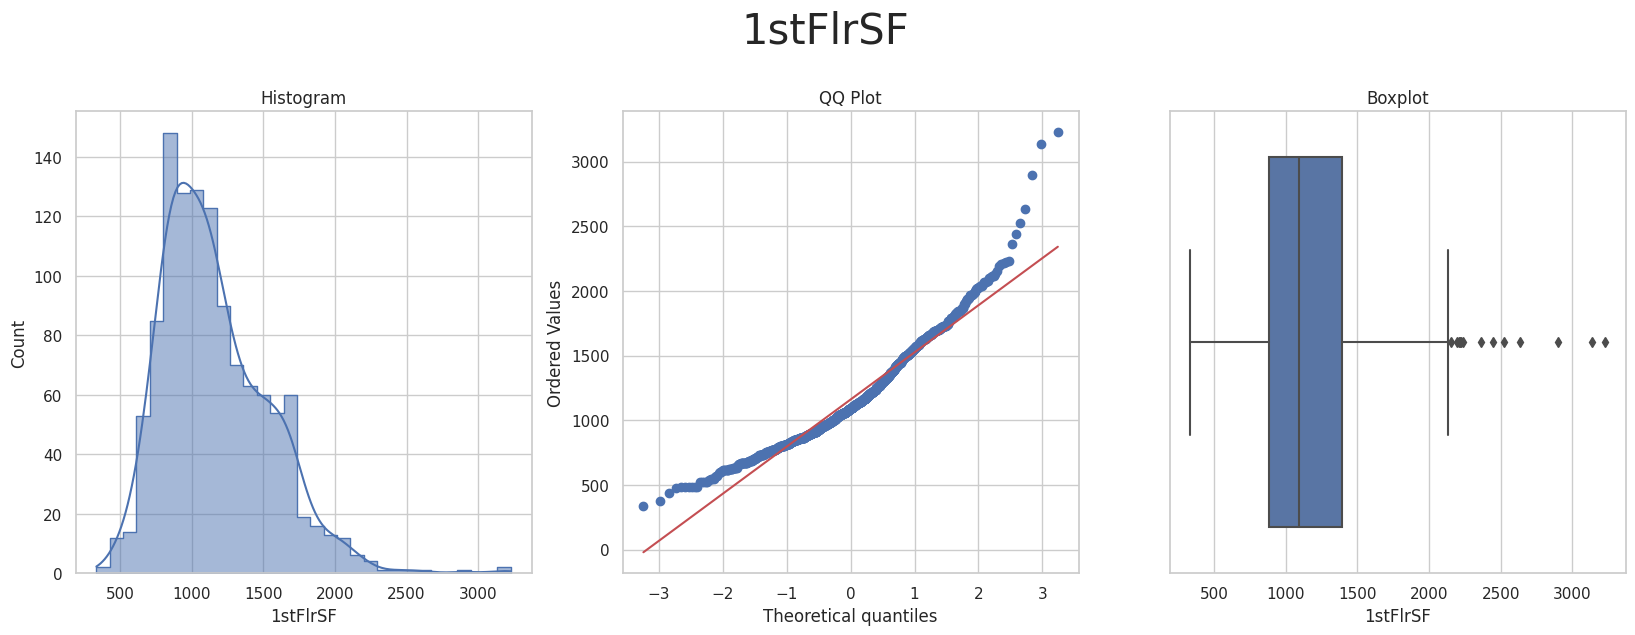

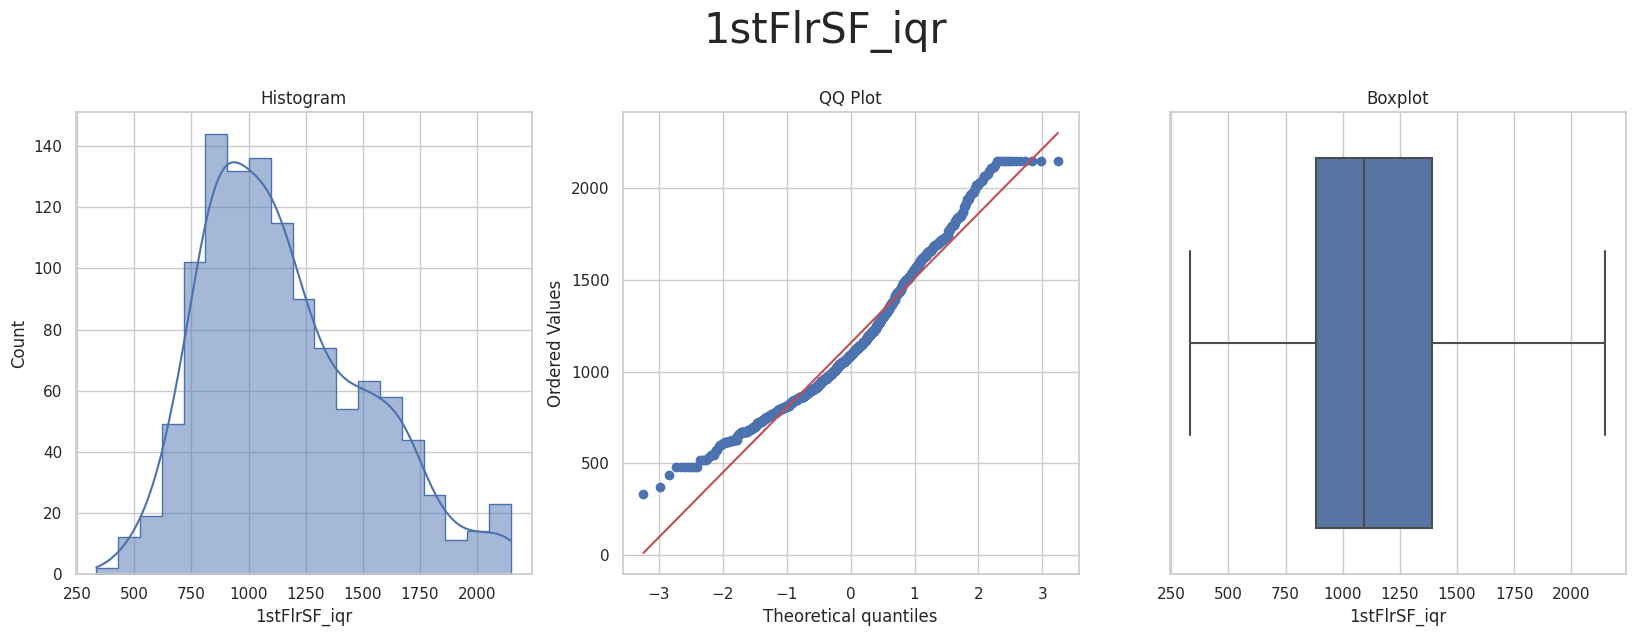



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_iqr'] 



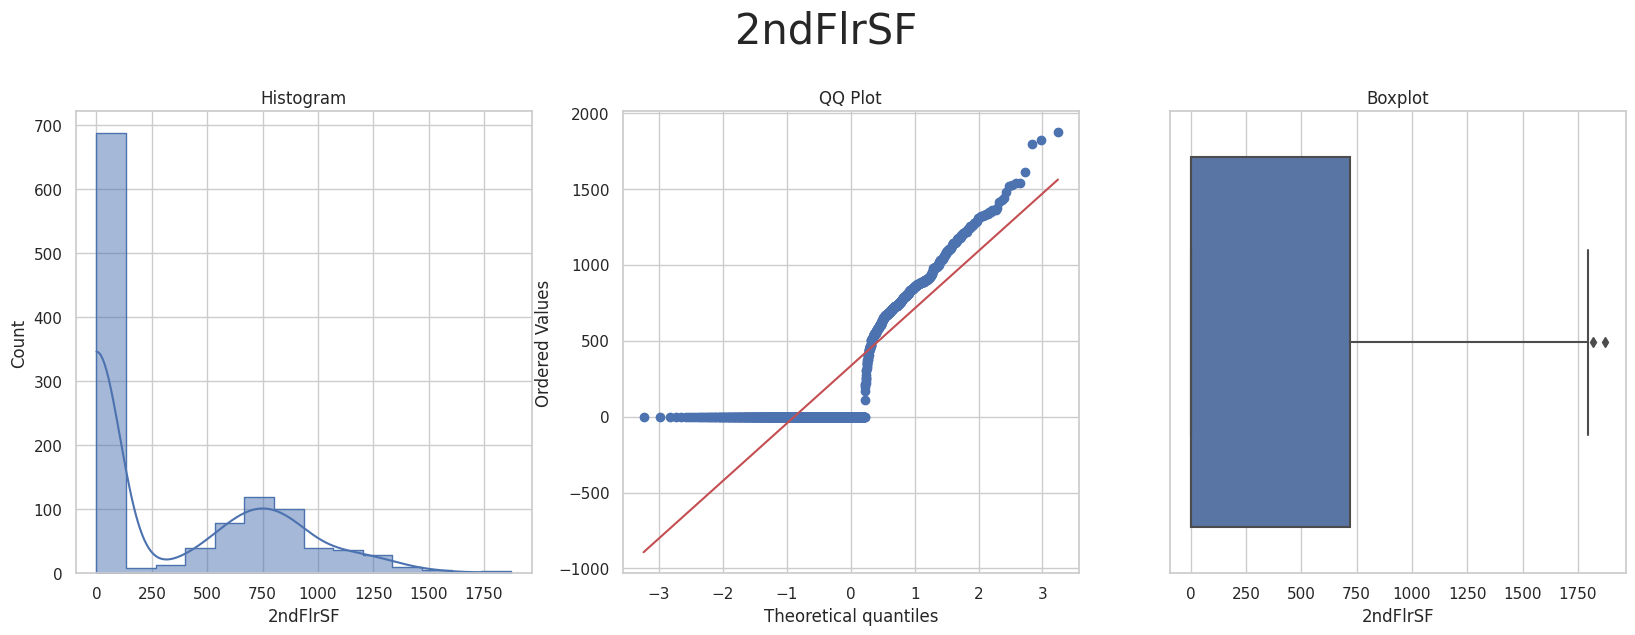

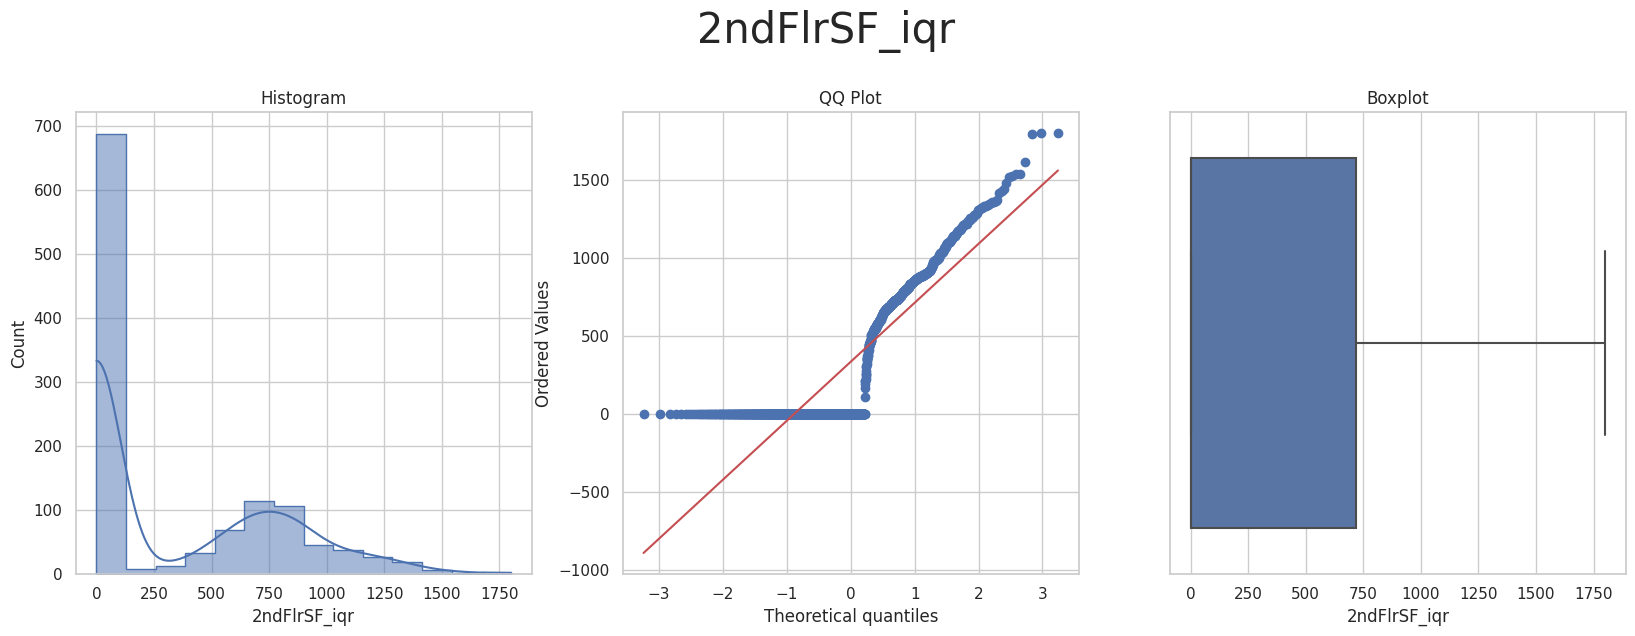



* Variable Analyzed: BedroomAbvGr
* Applied transformation: ['BedroomAbvGr_iqr'] 



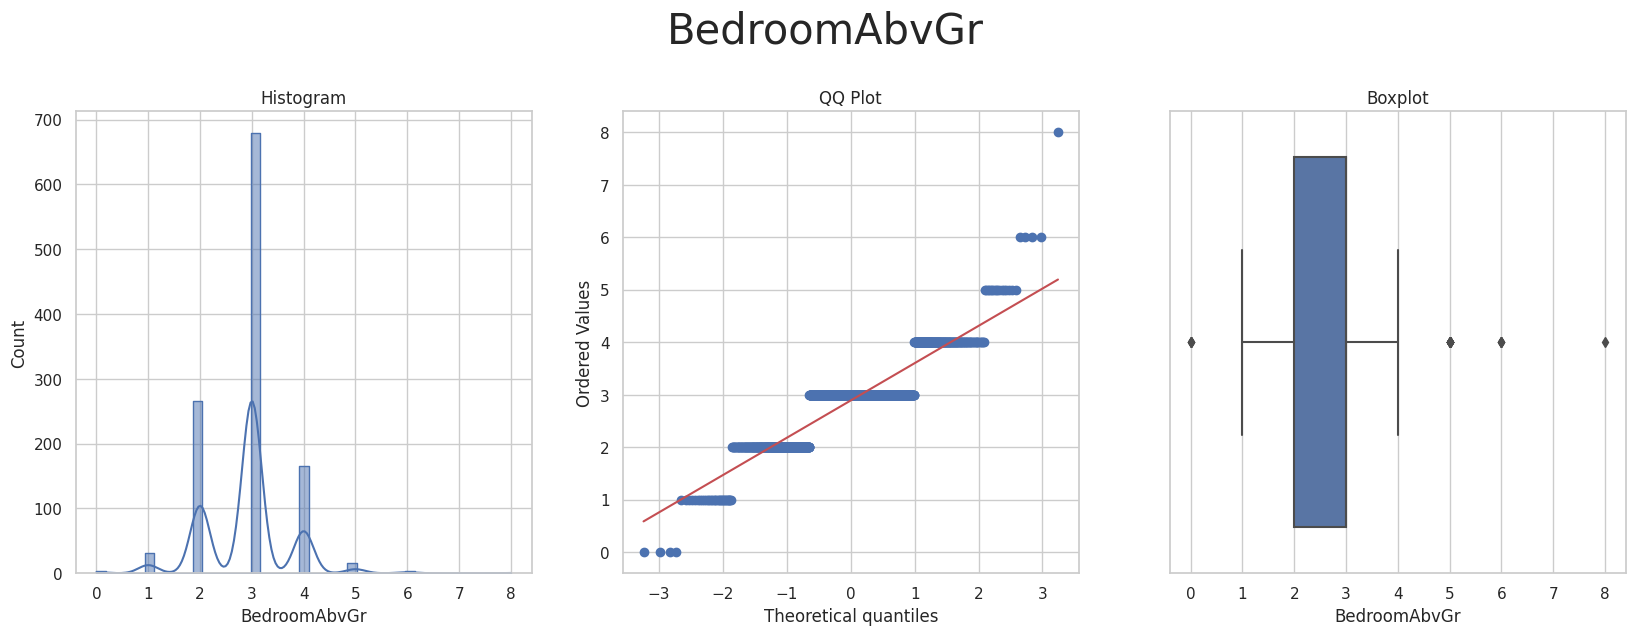

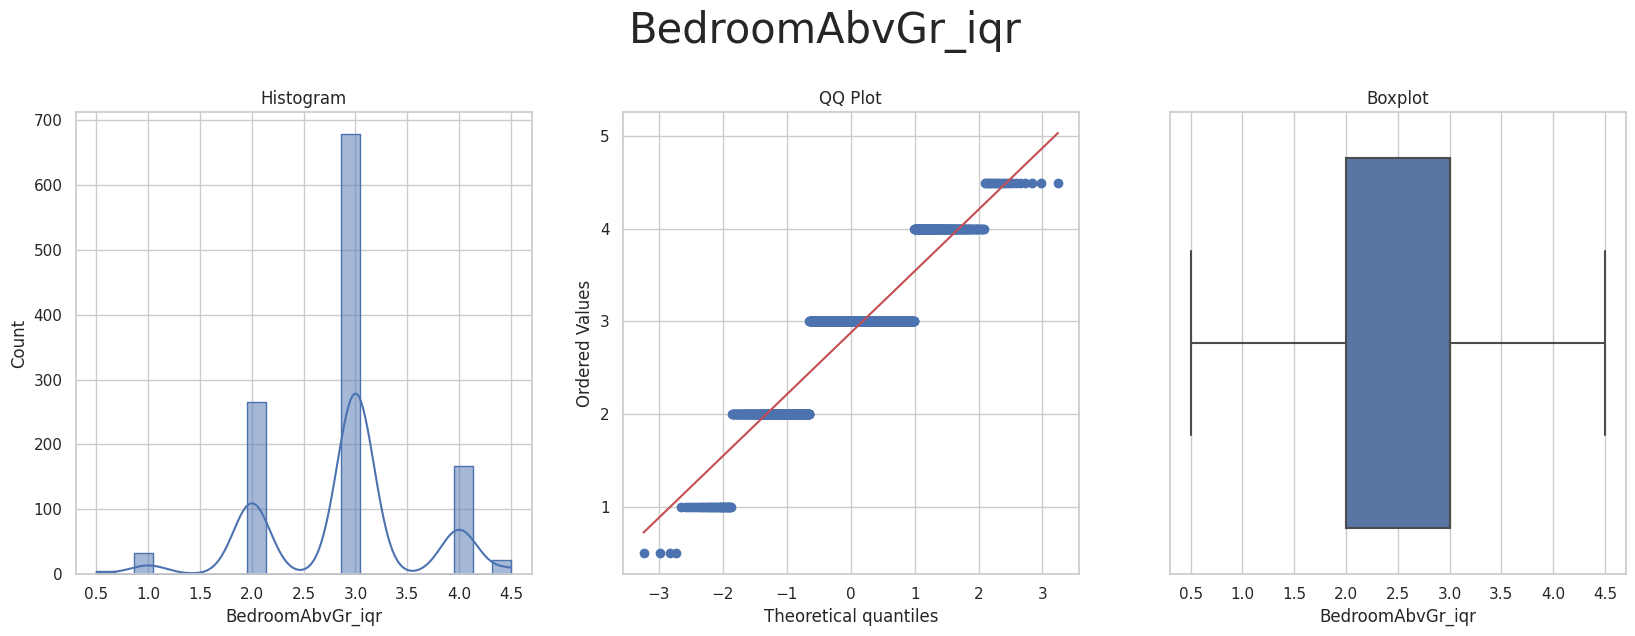



* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_iqr'] 



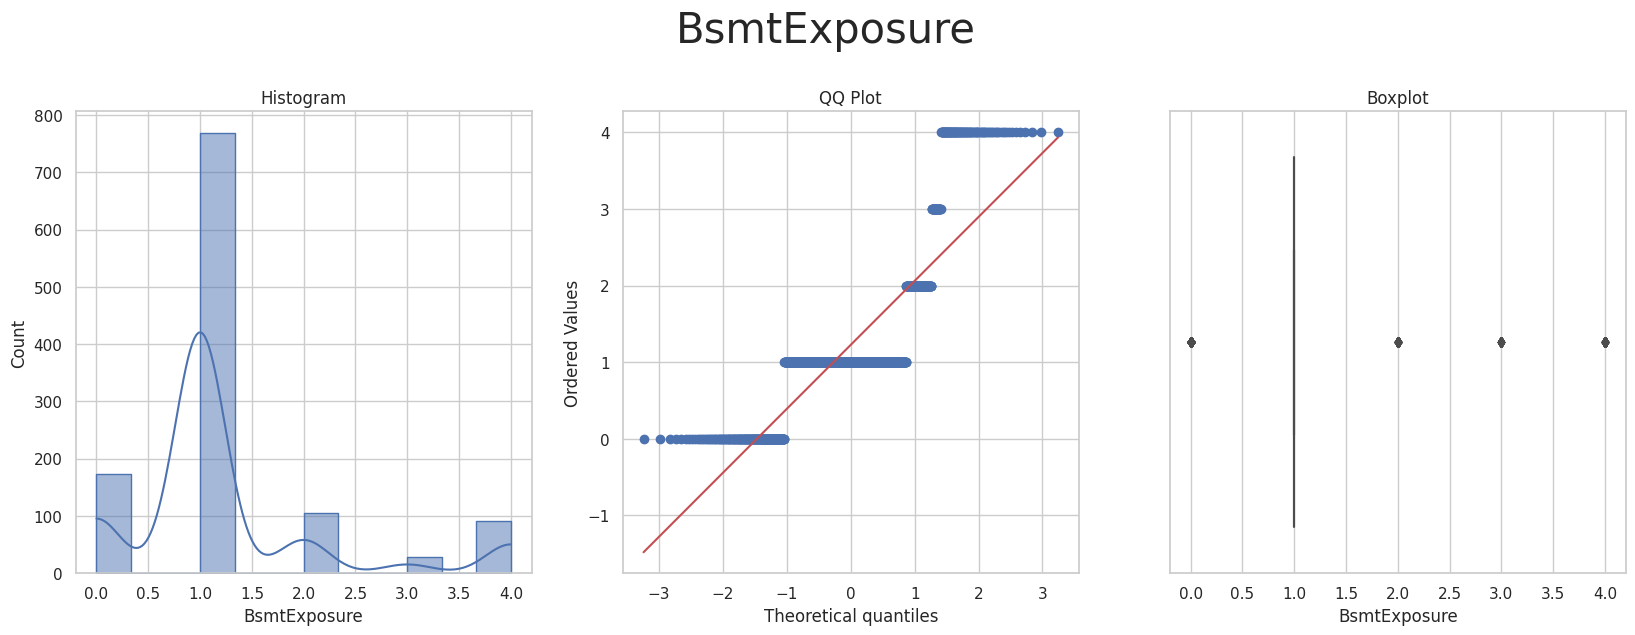

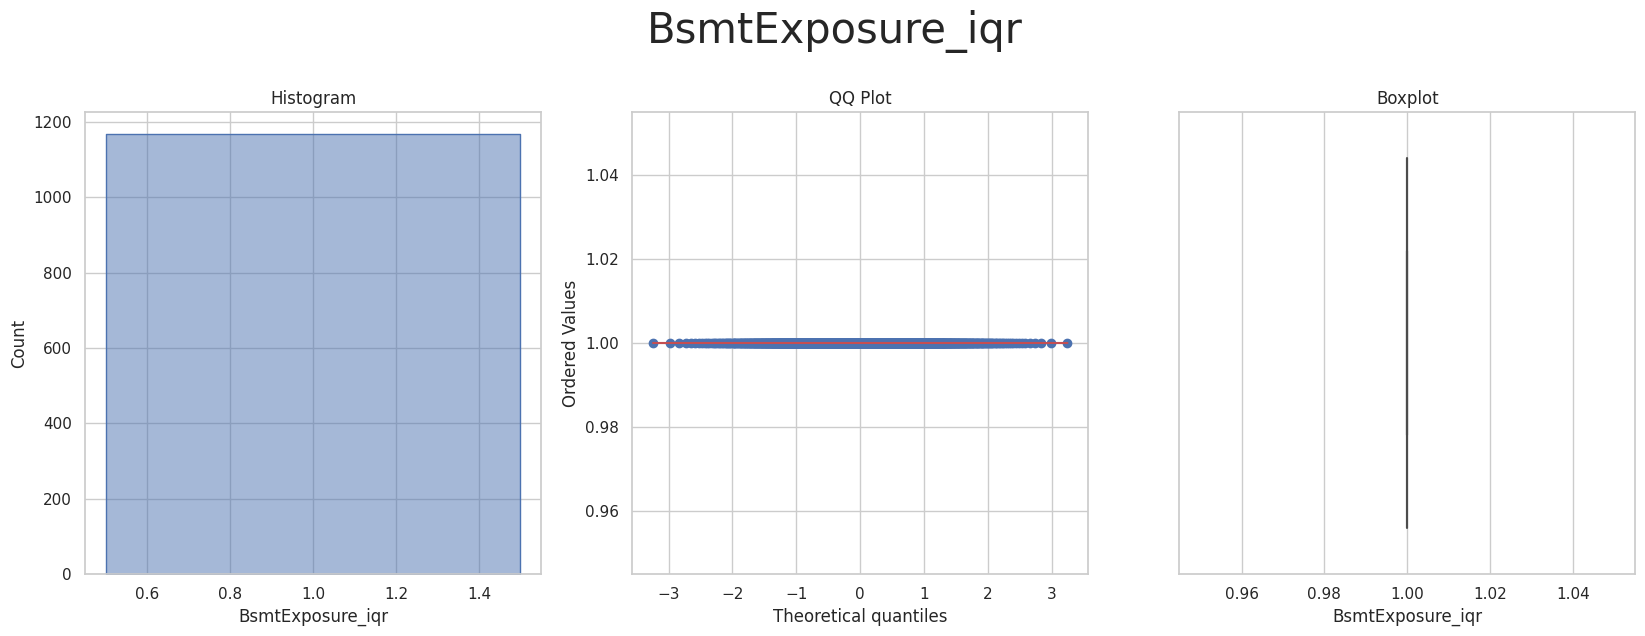



* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_iqr'] 



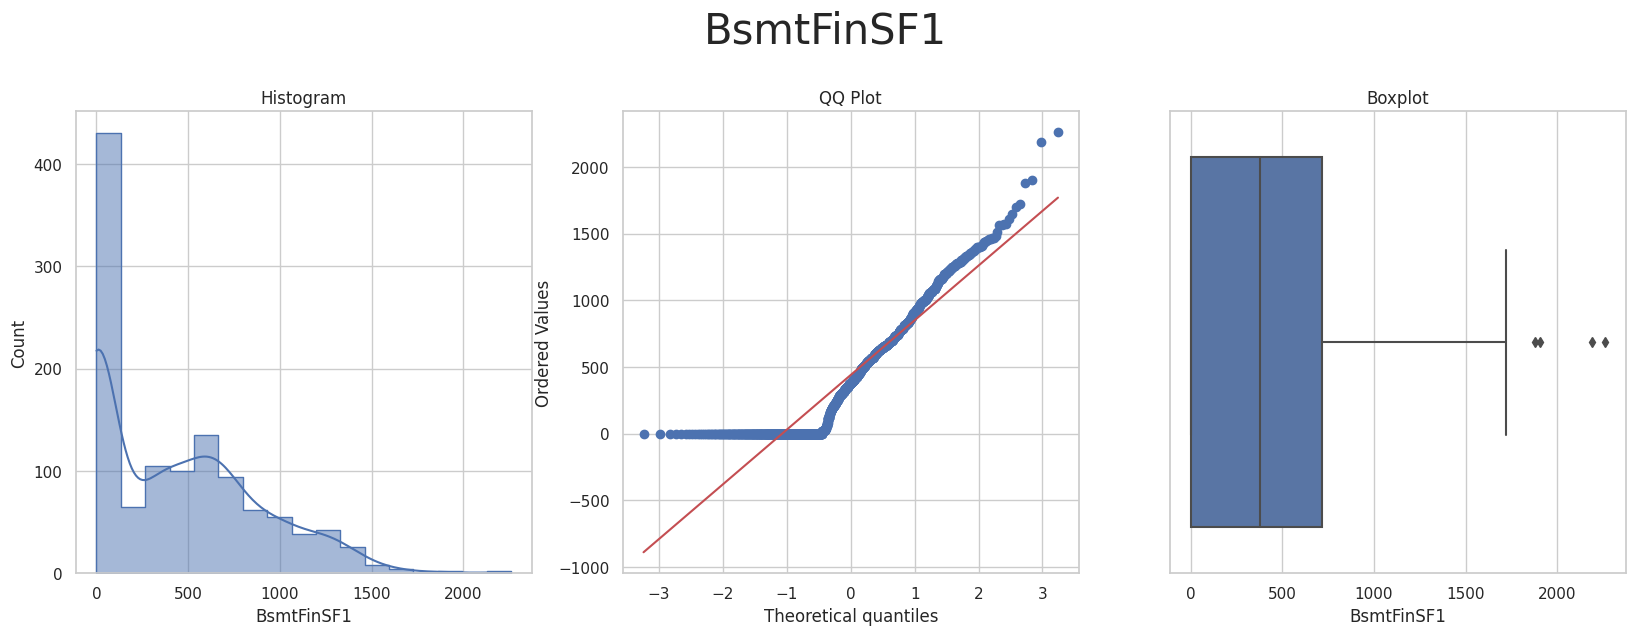

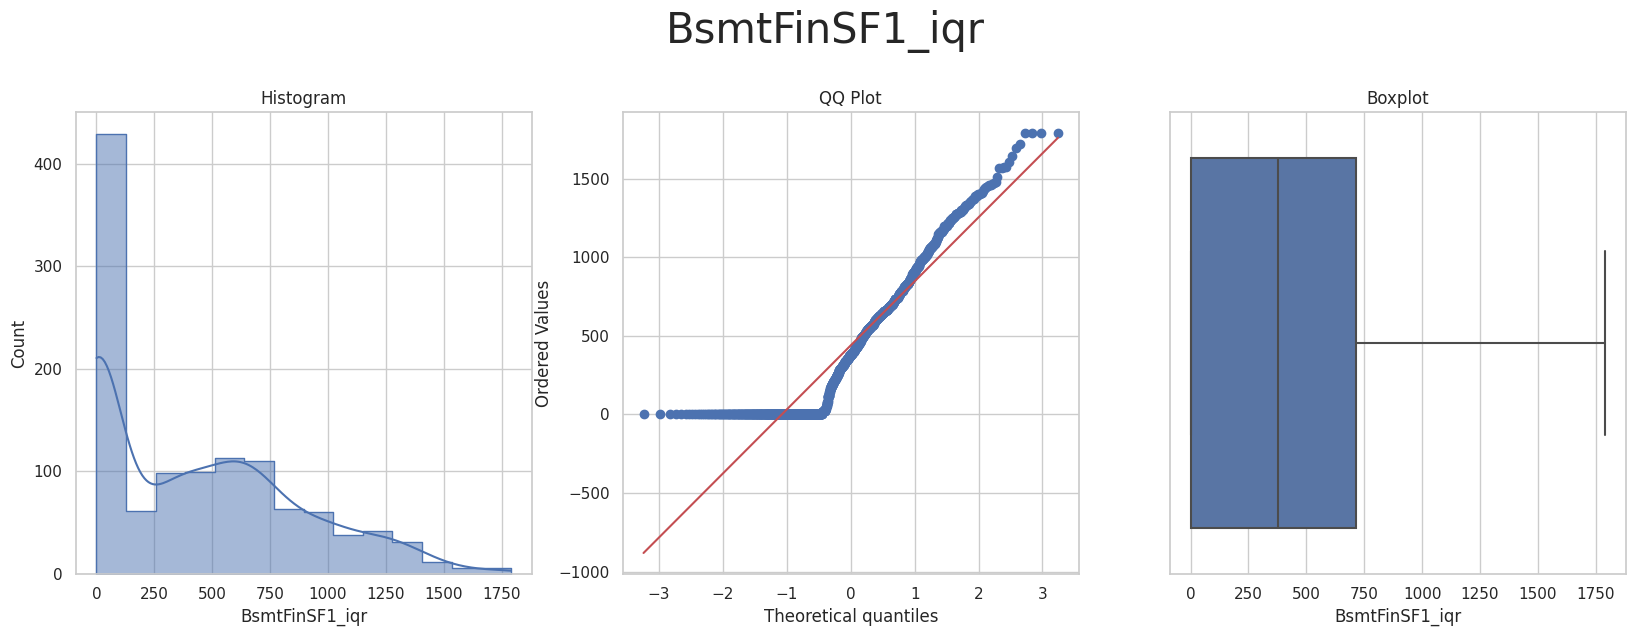



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_iqr'] 



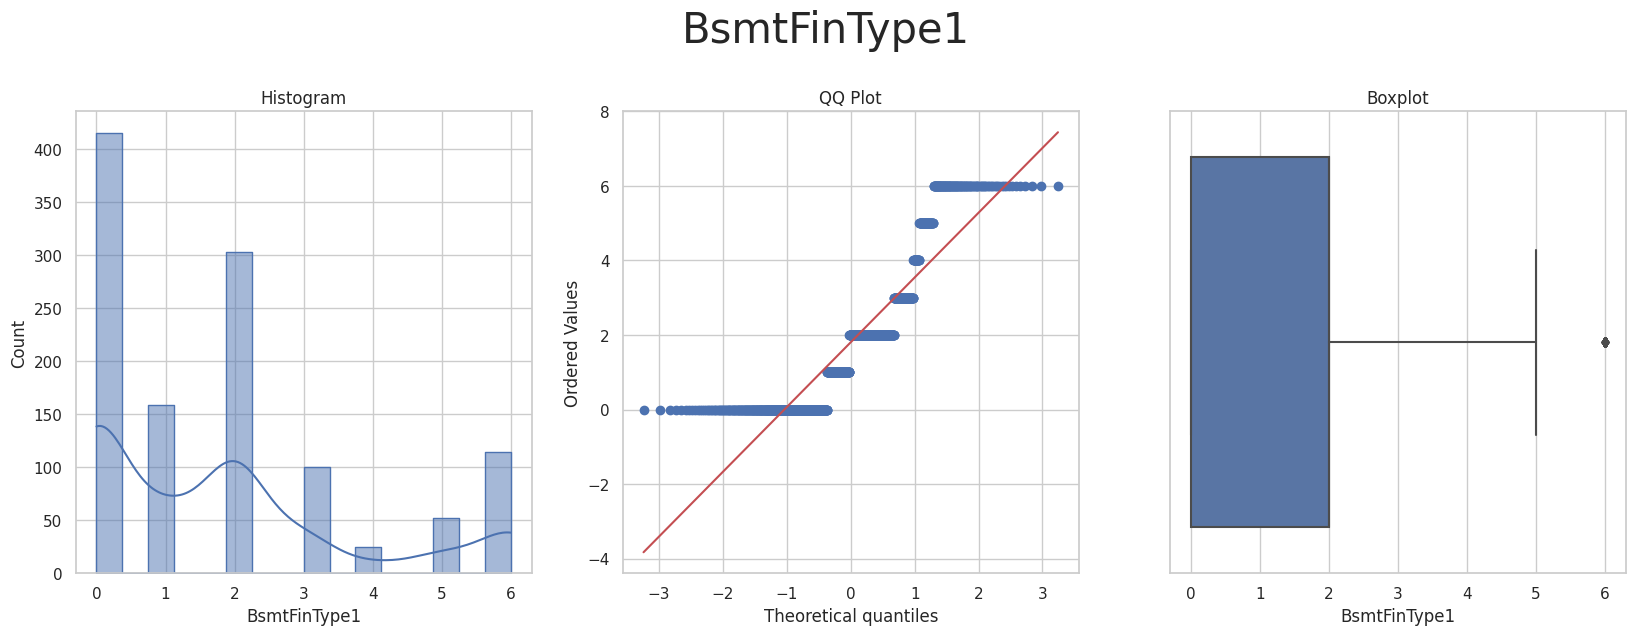

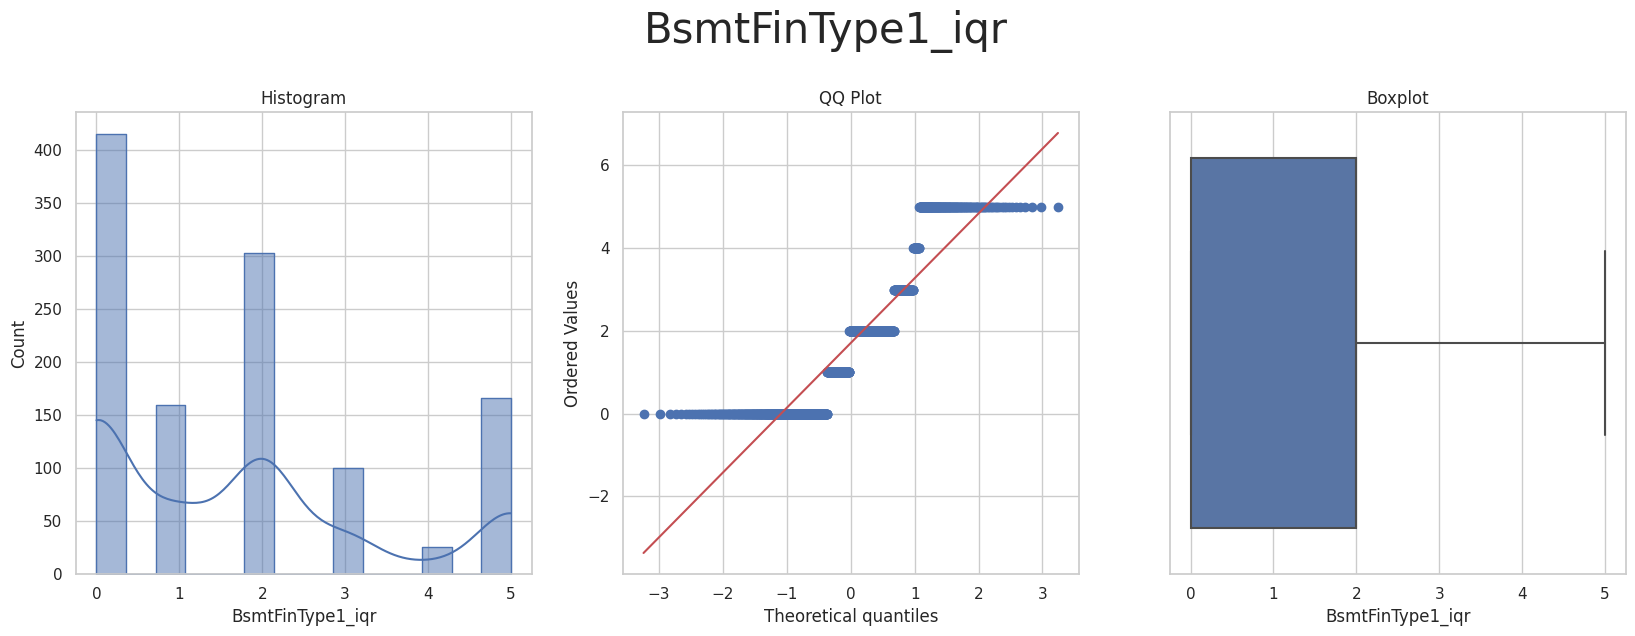



* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_iqr'] 



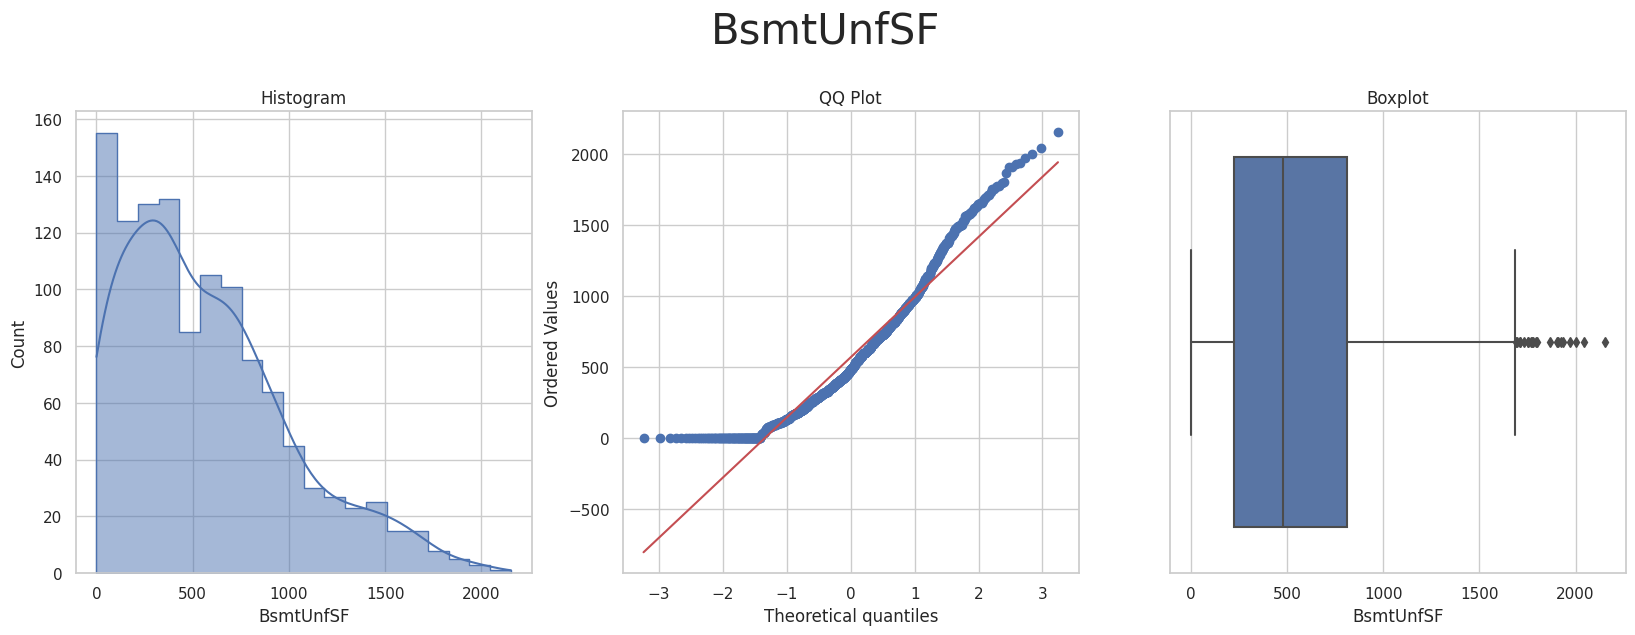

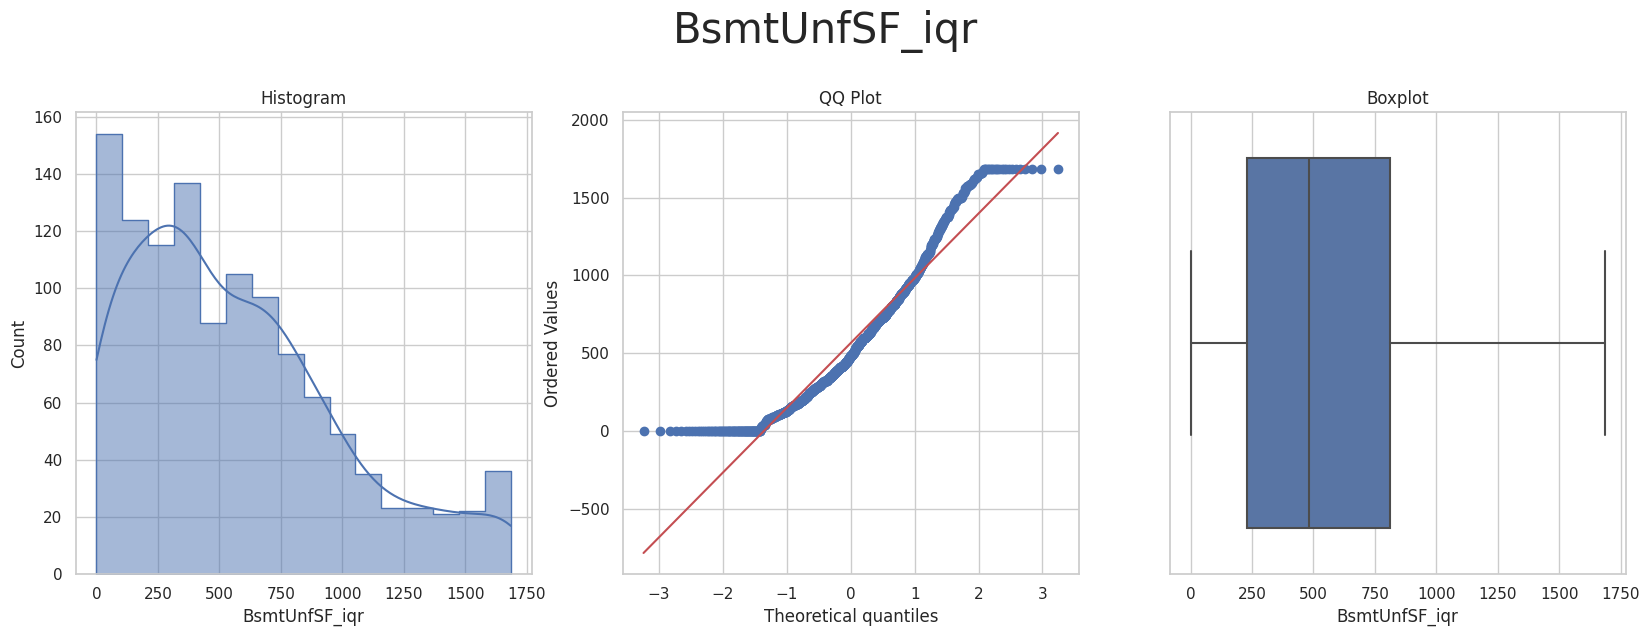



* Variable Analyzed: EnclosedPorch
* Applied transformation: ['EnclosedPorch_iqr'] 



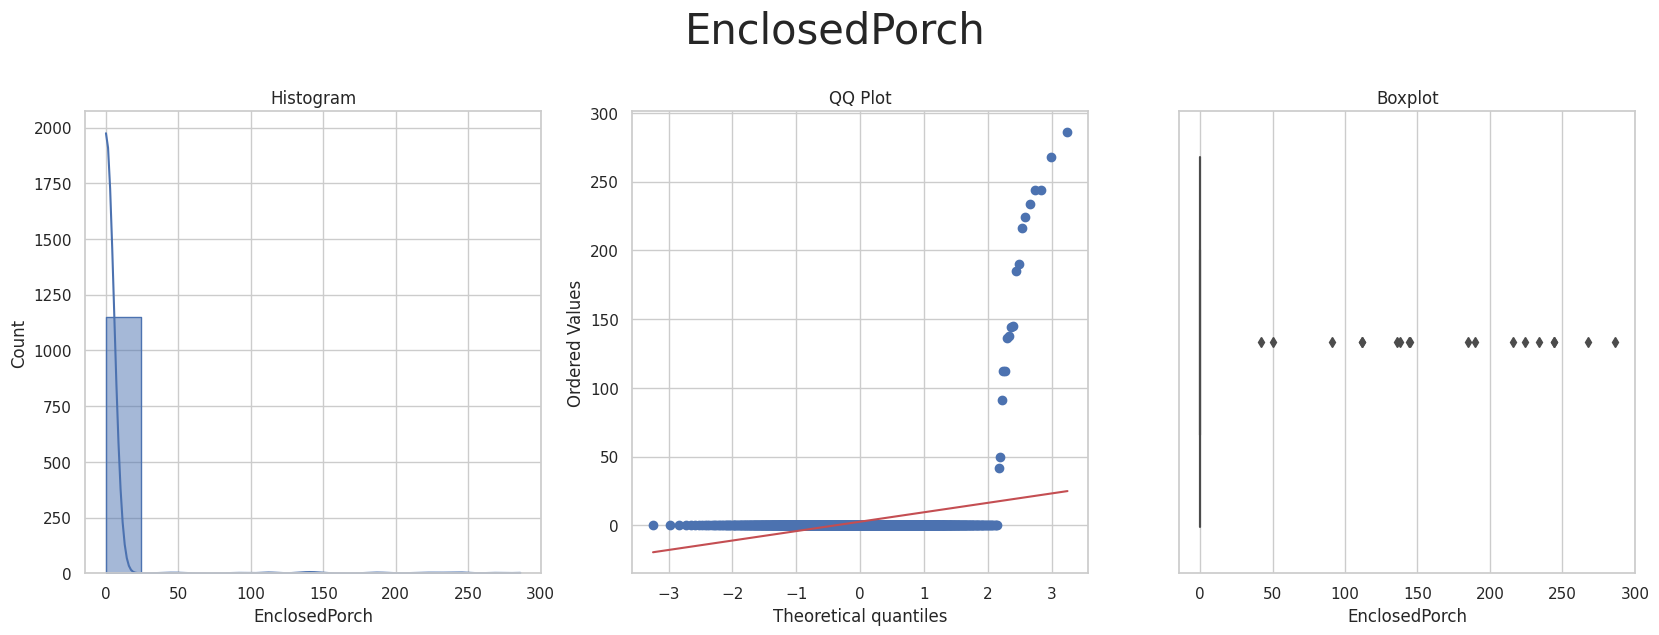

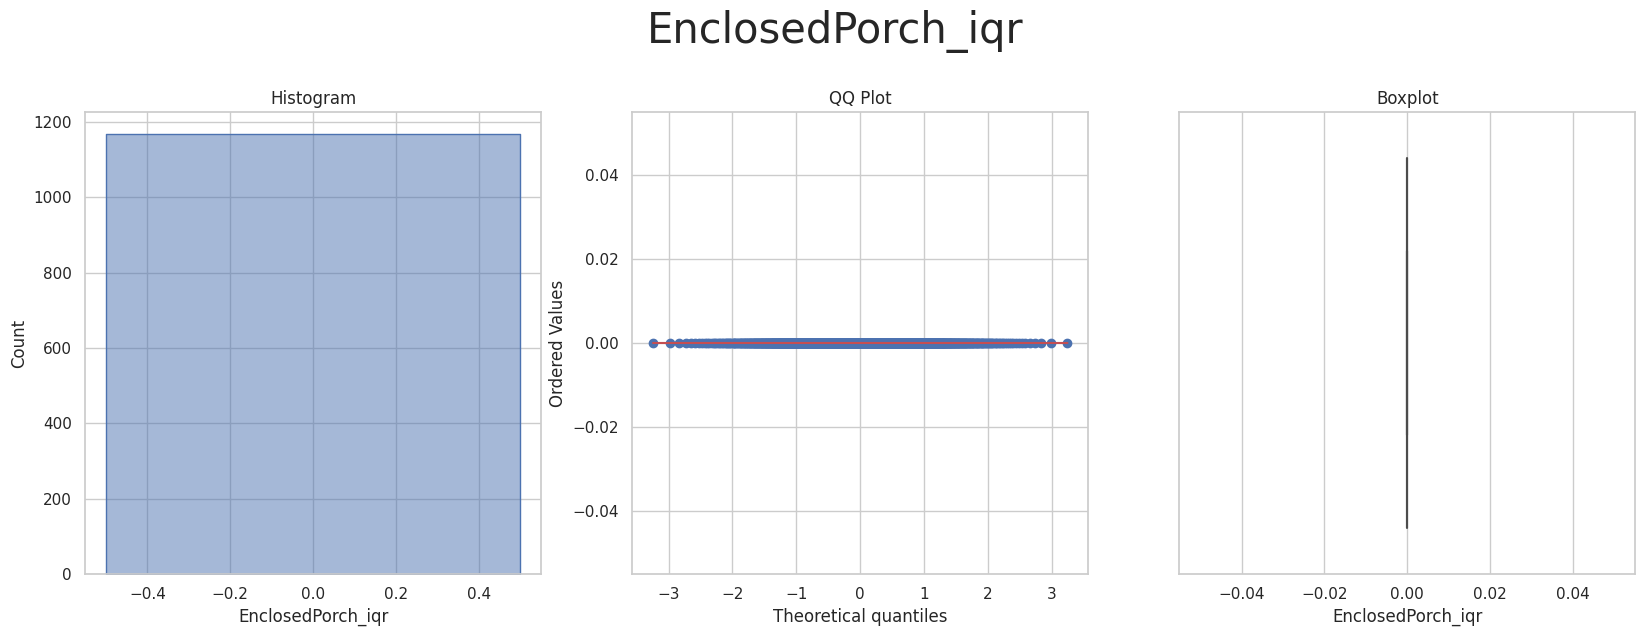



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_iqr'] 



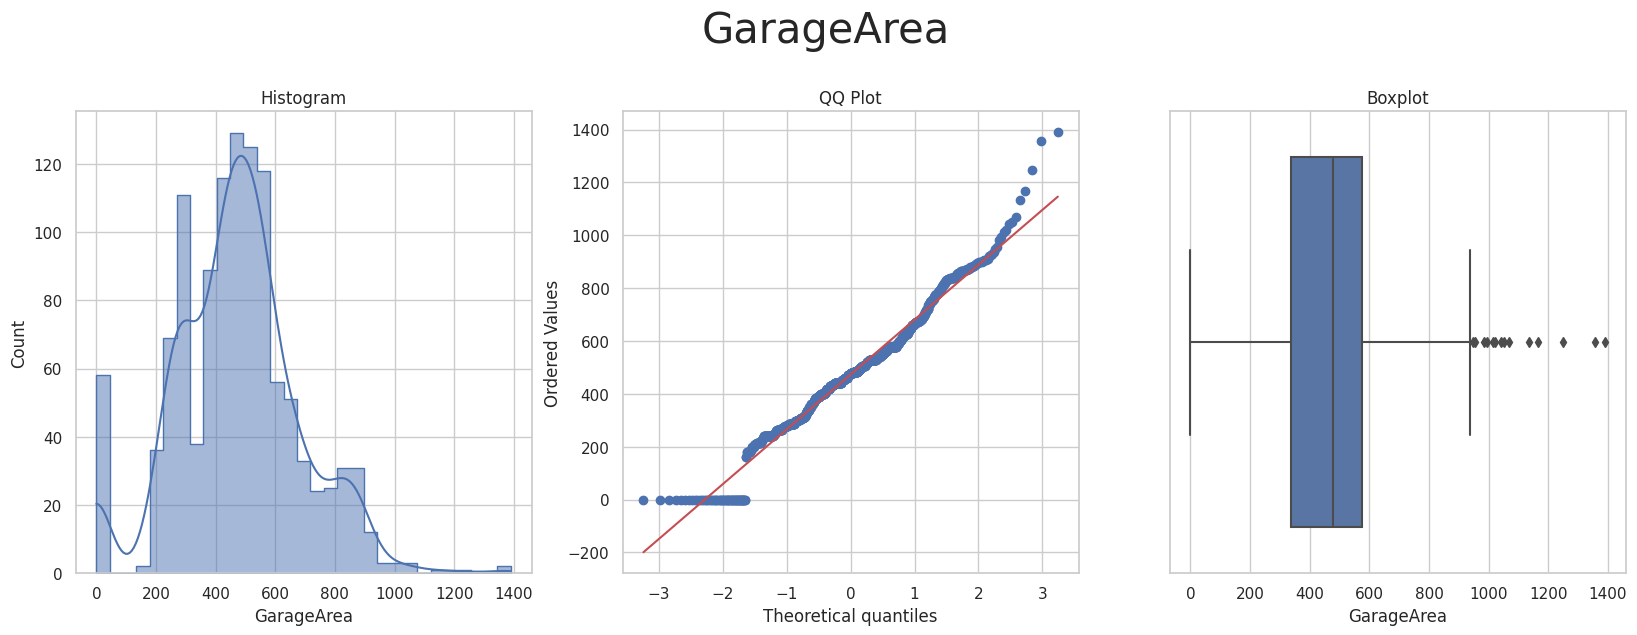

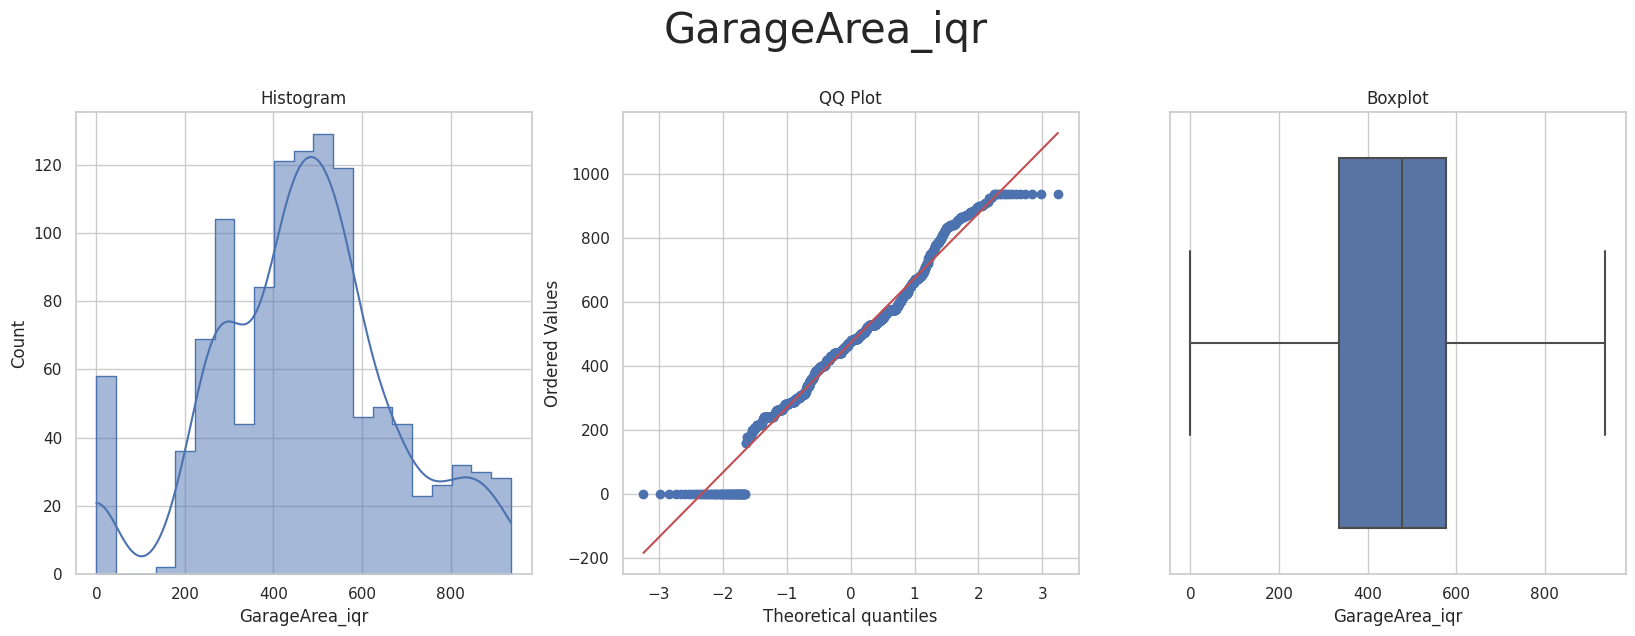



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_iqr'] 



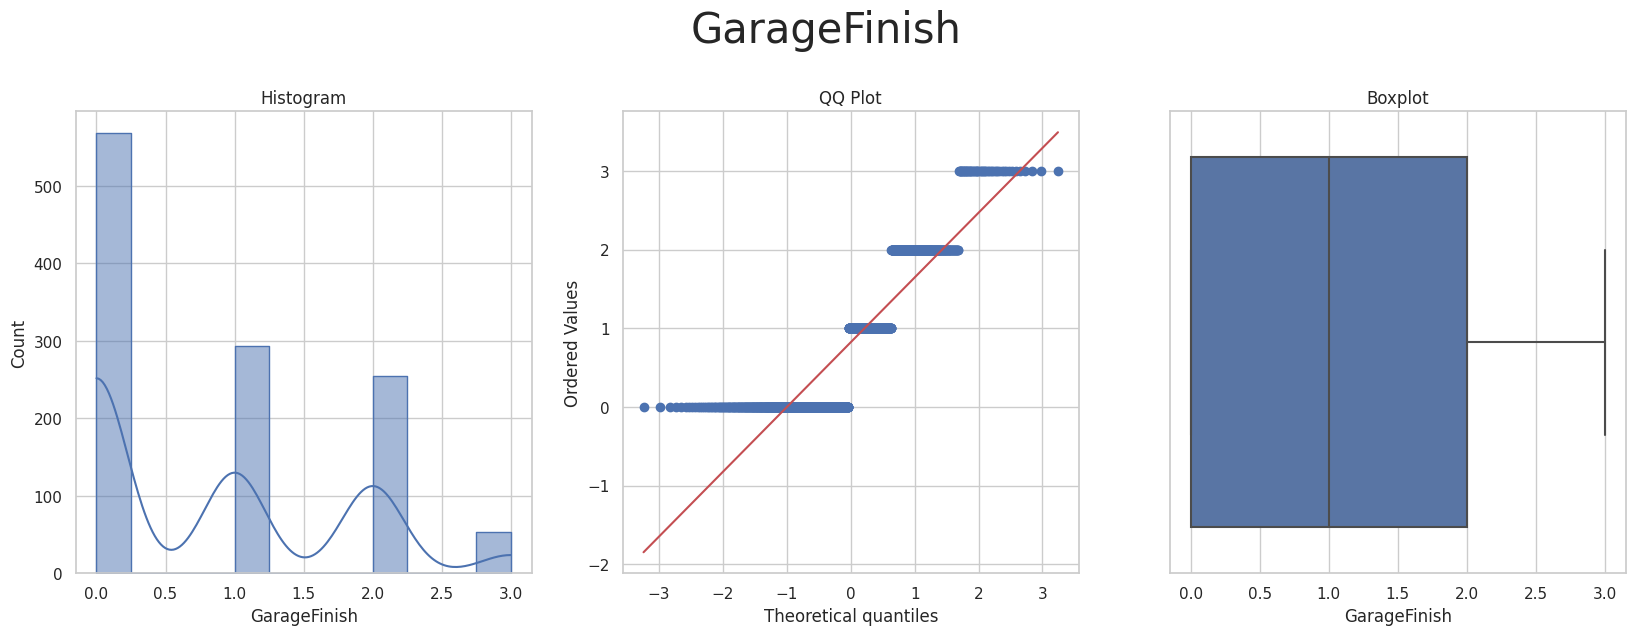

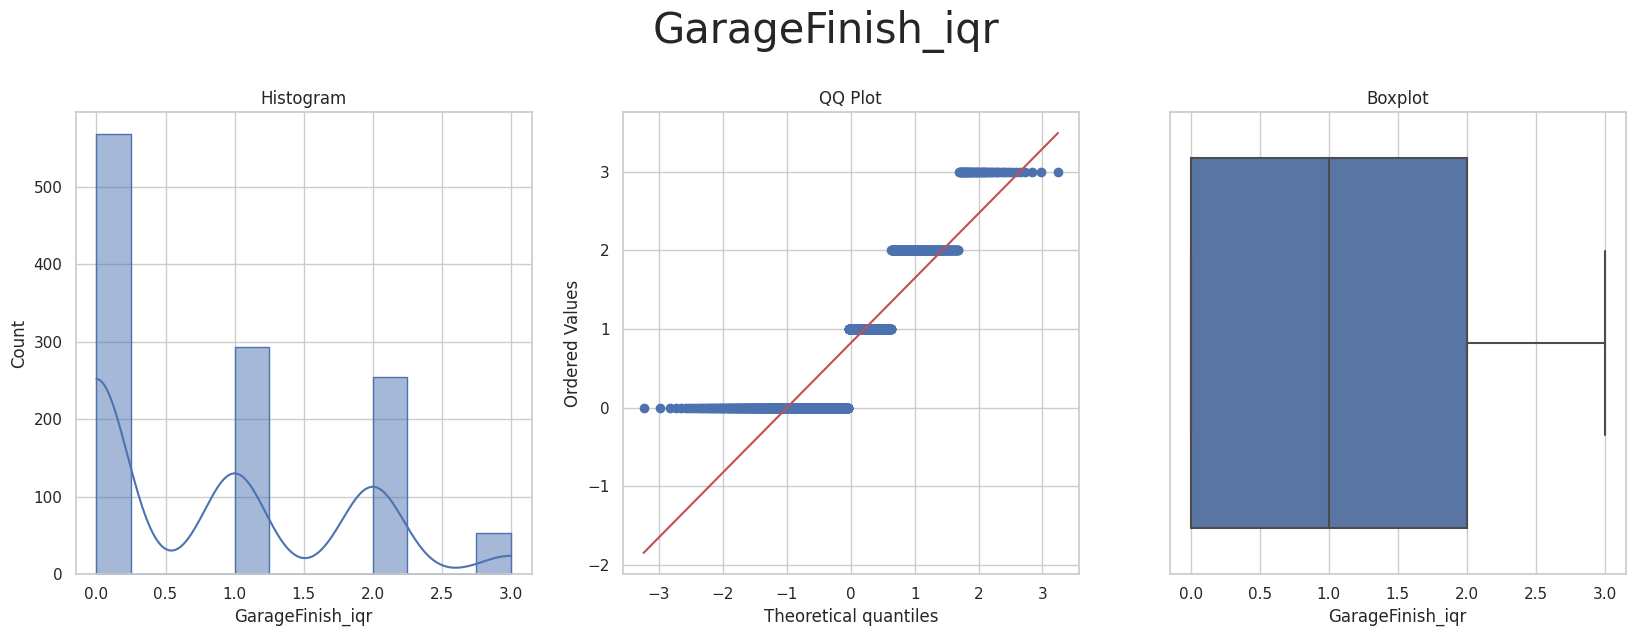



* Variable Analyzed: GarageYrBlt
* Applied transformation: ['GarageYrBlt_iqr'] 



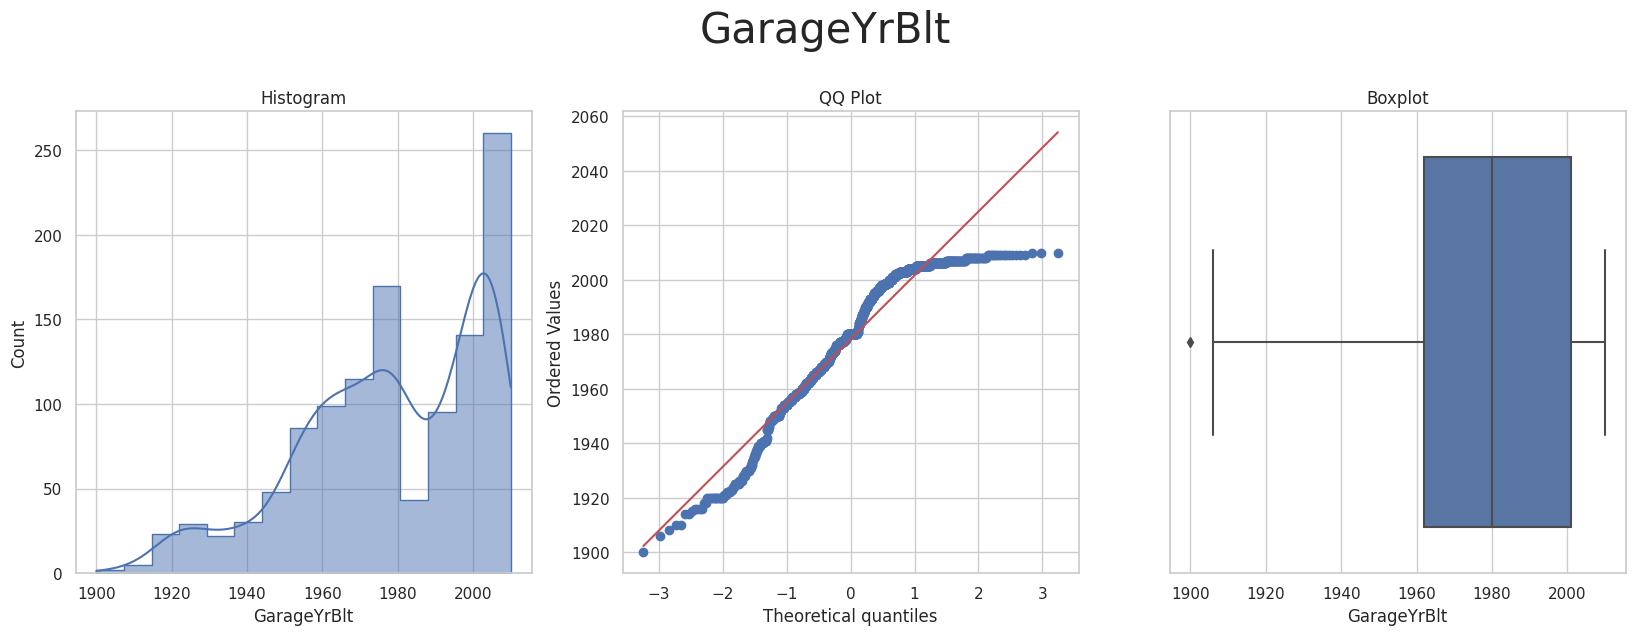

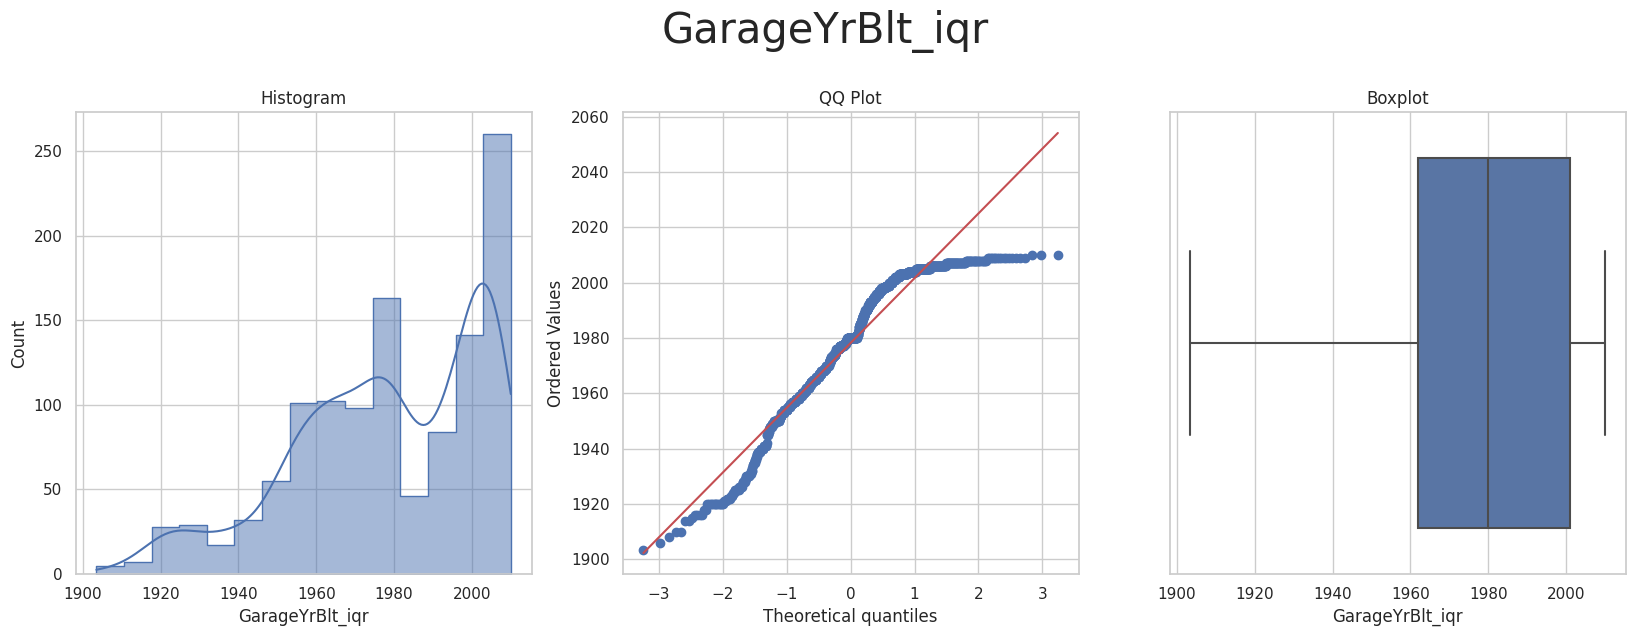



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_iqr'] 



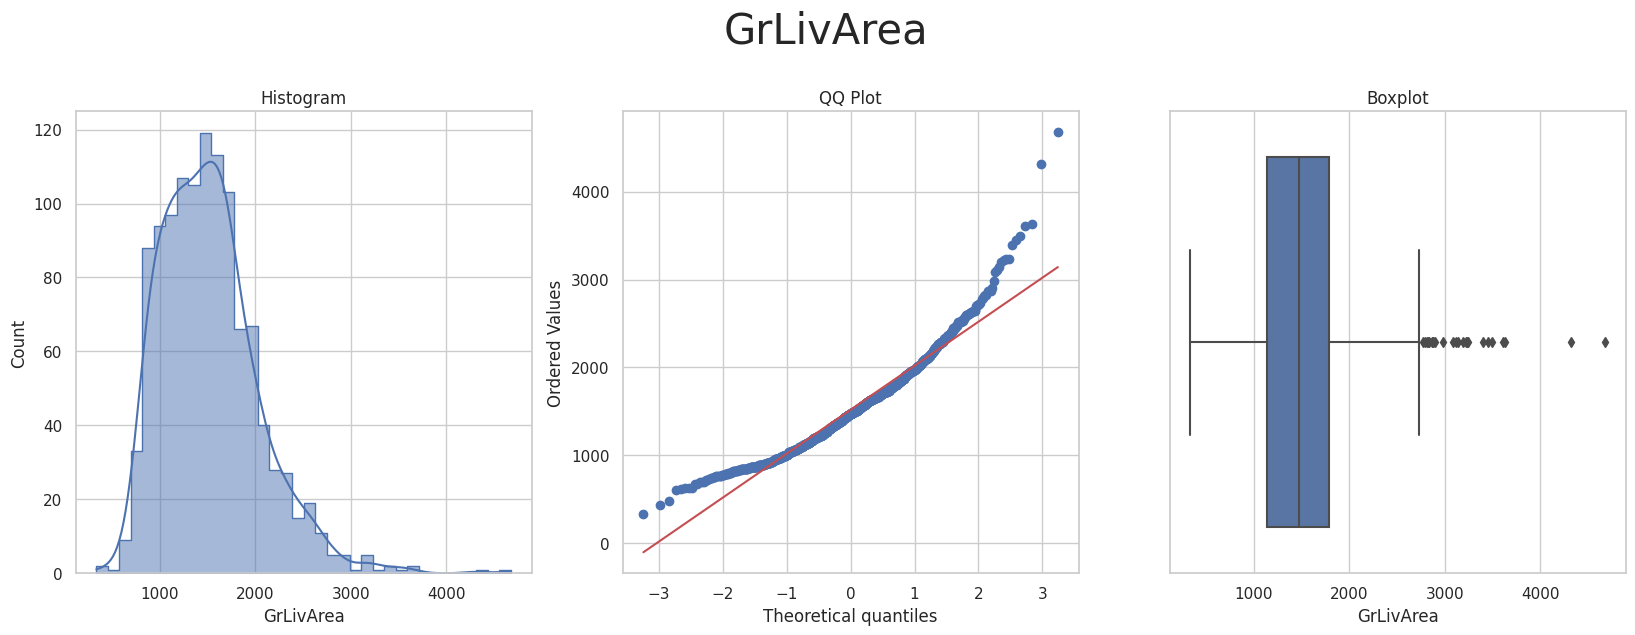

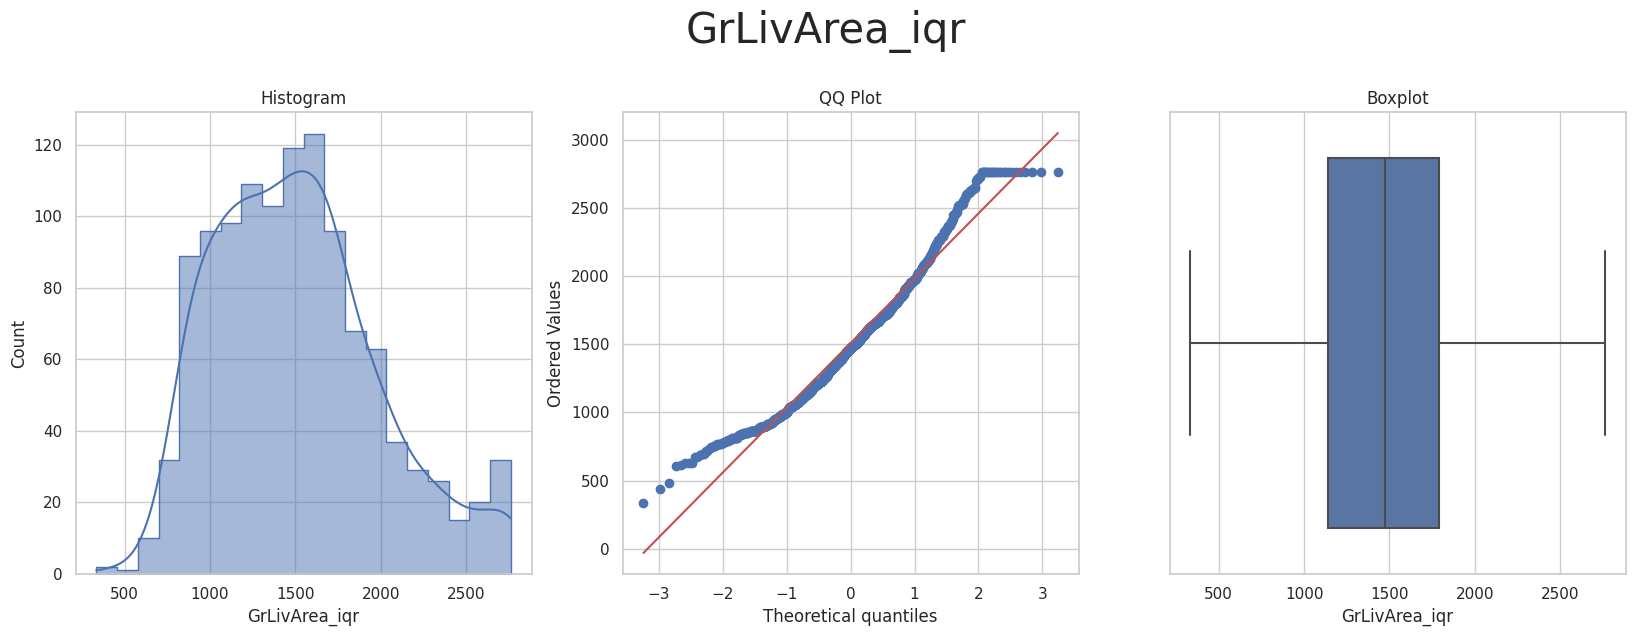



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_iqr'] 



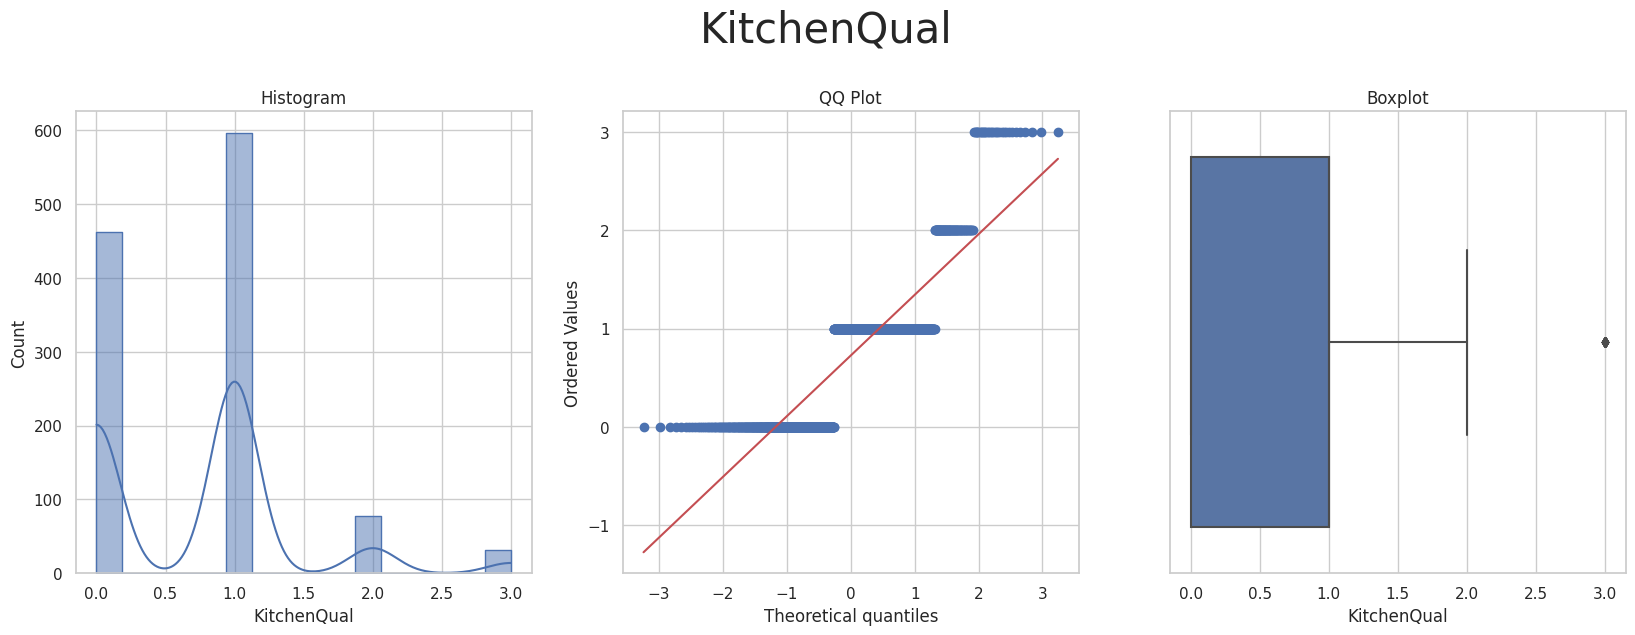

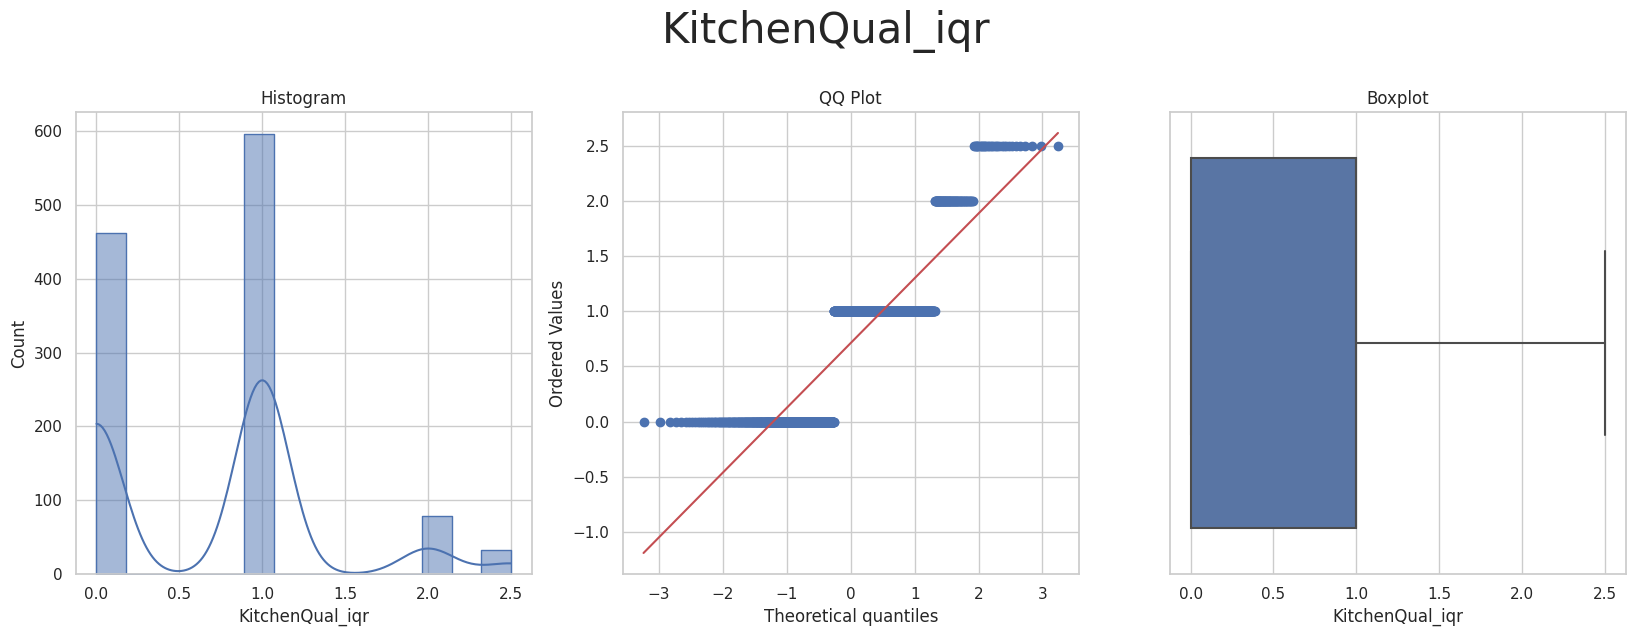



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_iqr'] 



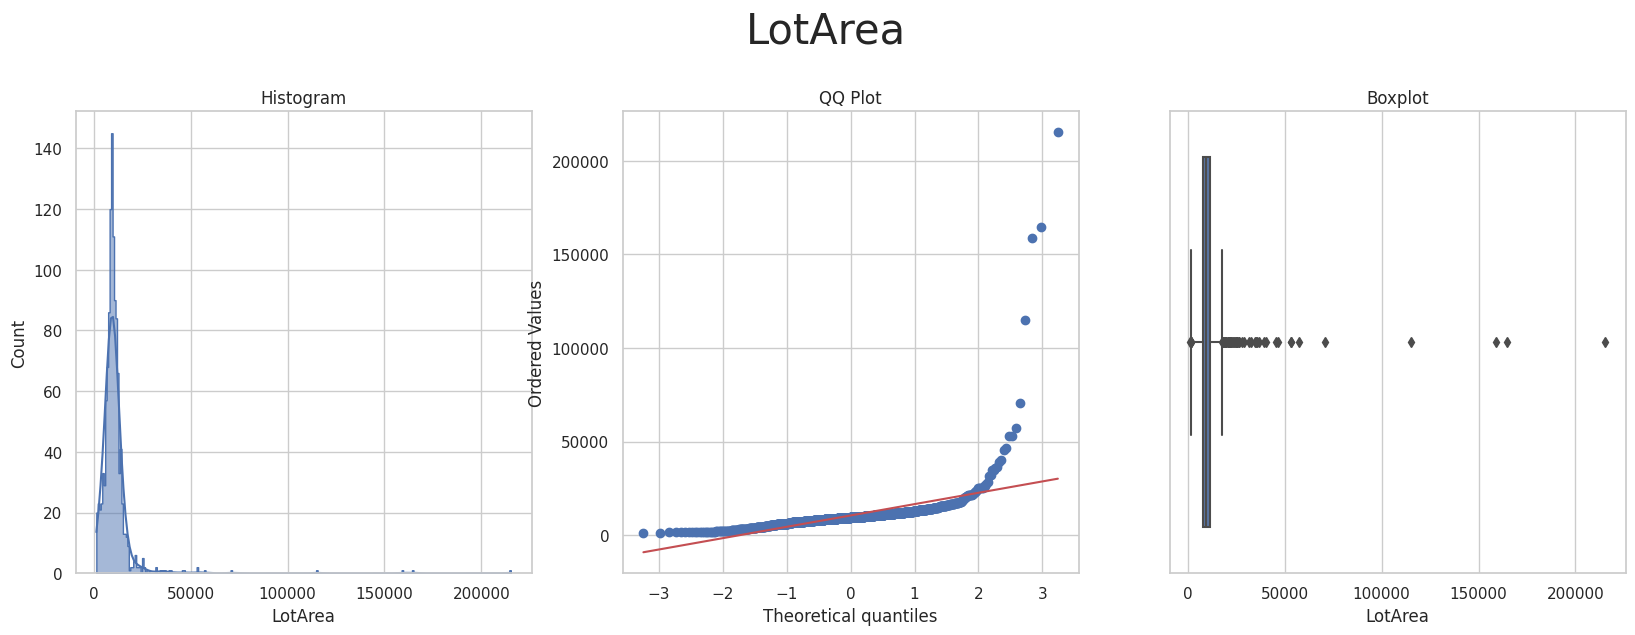

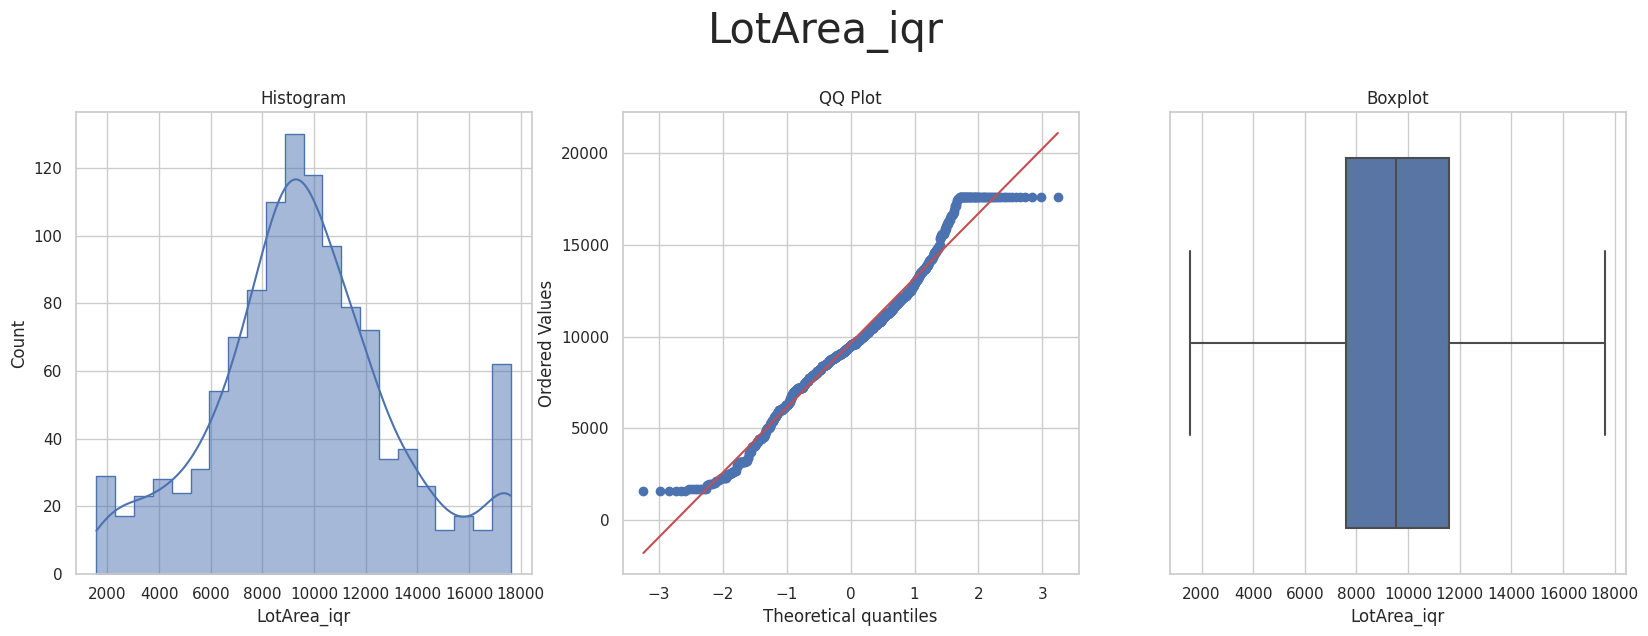



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_iqr'] 



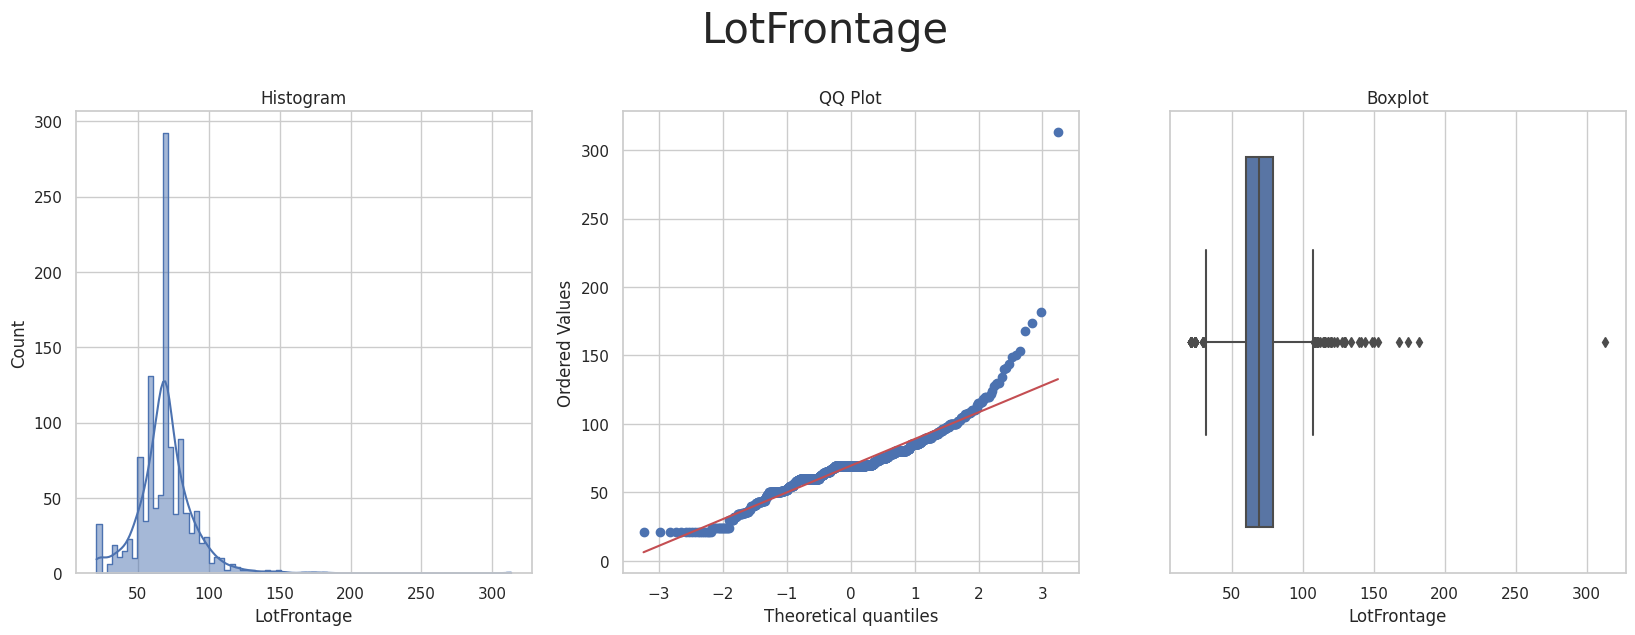

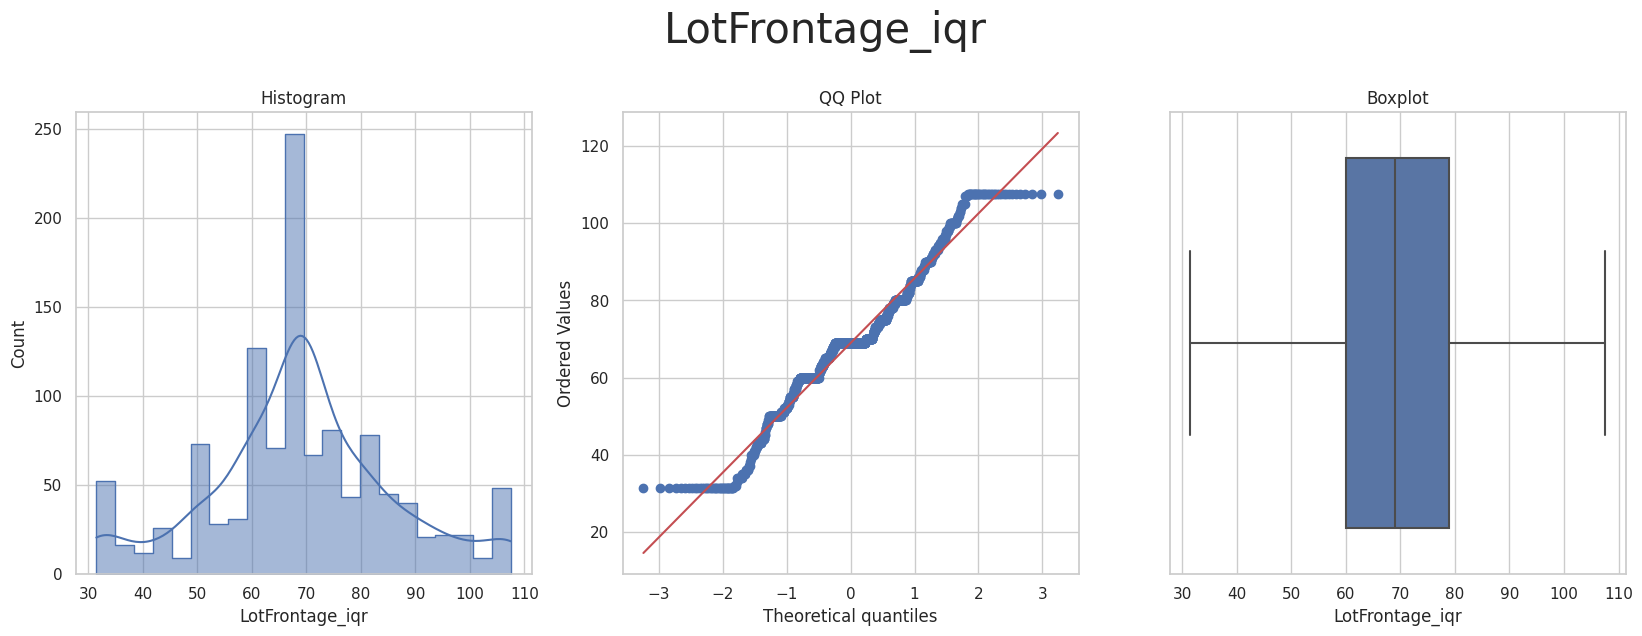



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_iqr'] 



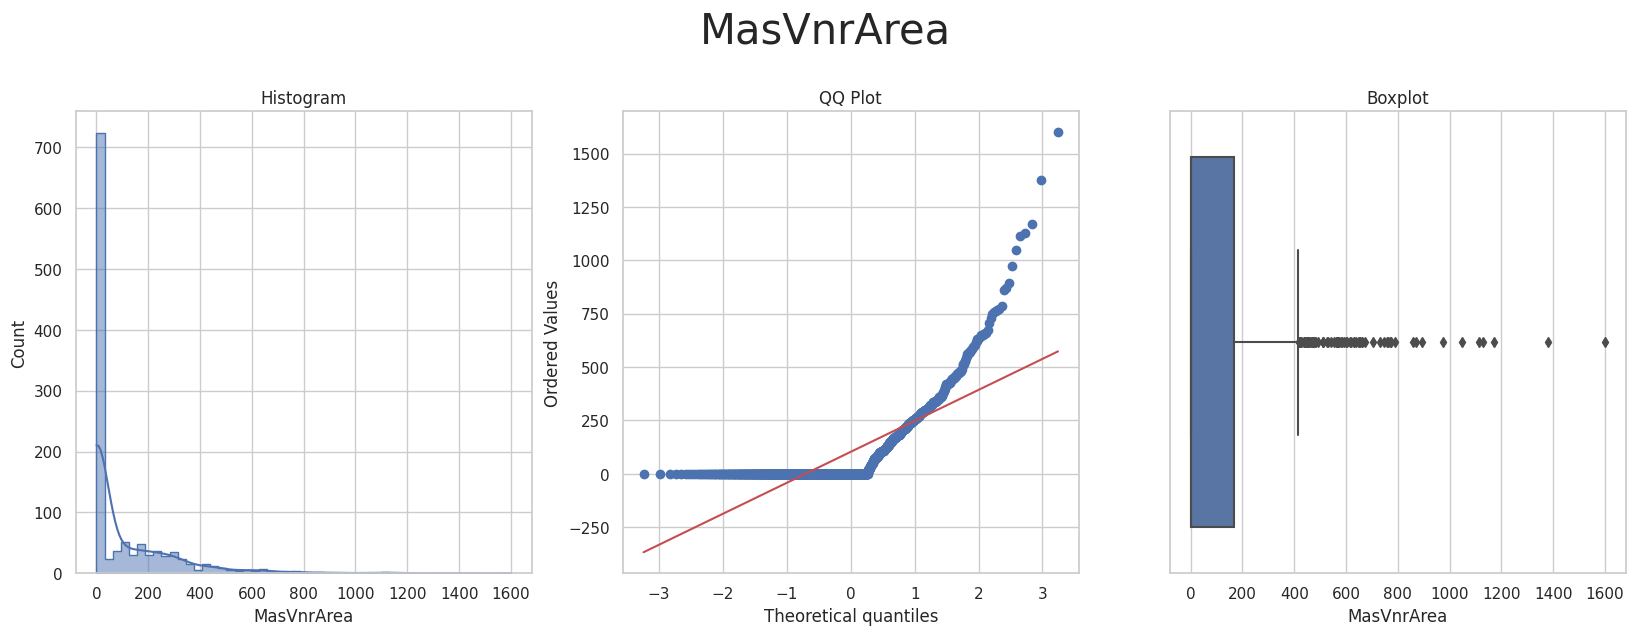

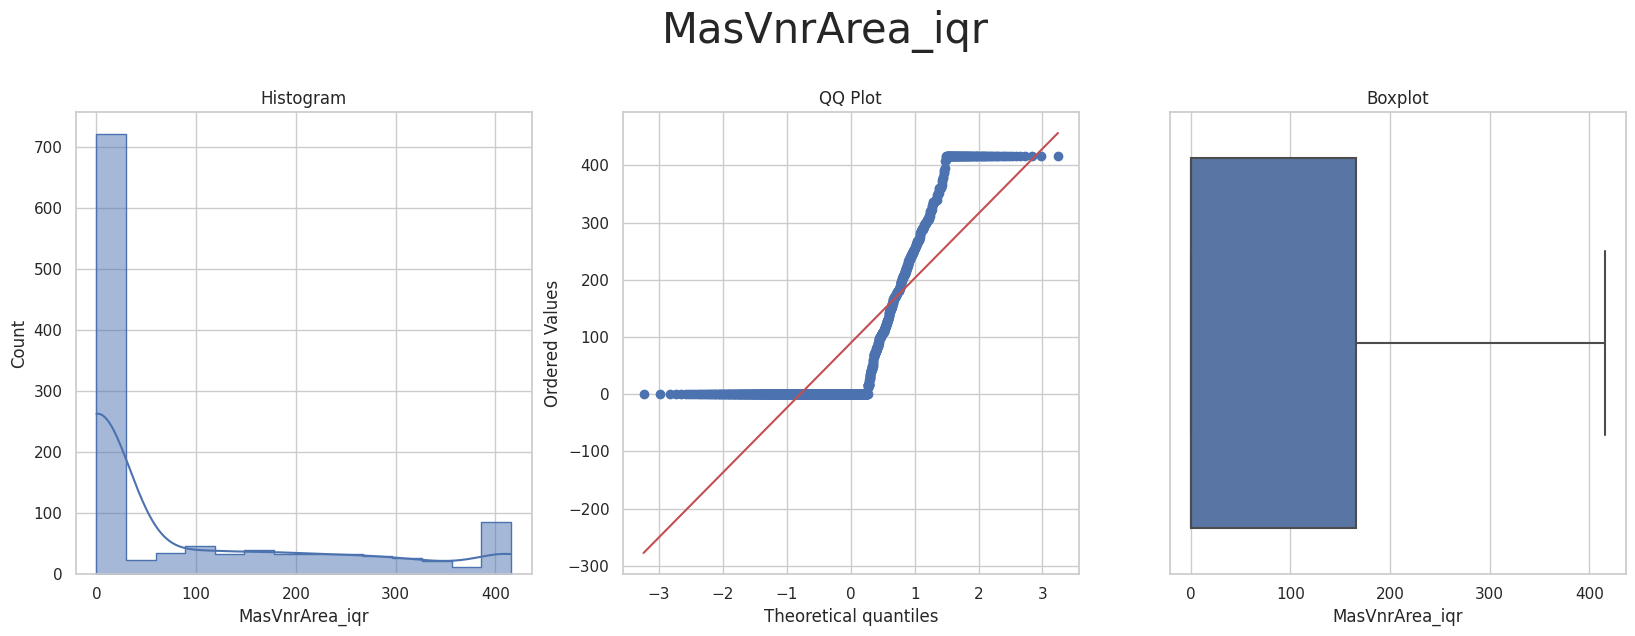



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_iqr'] 



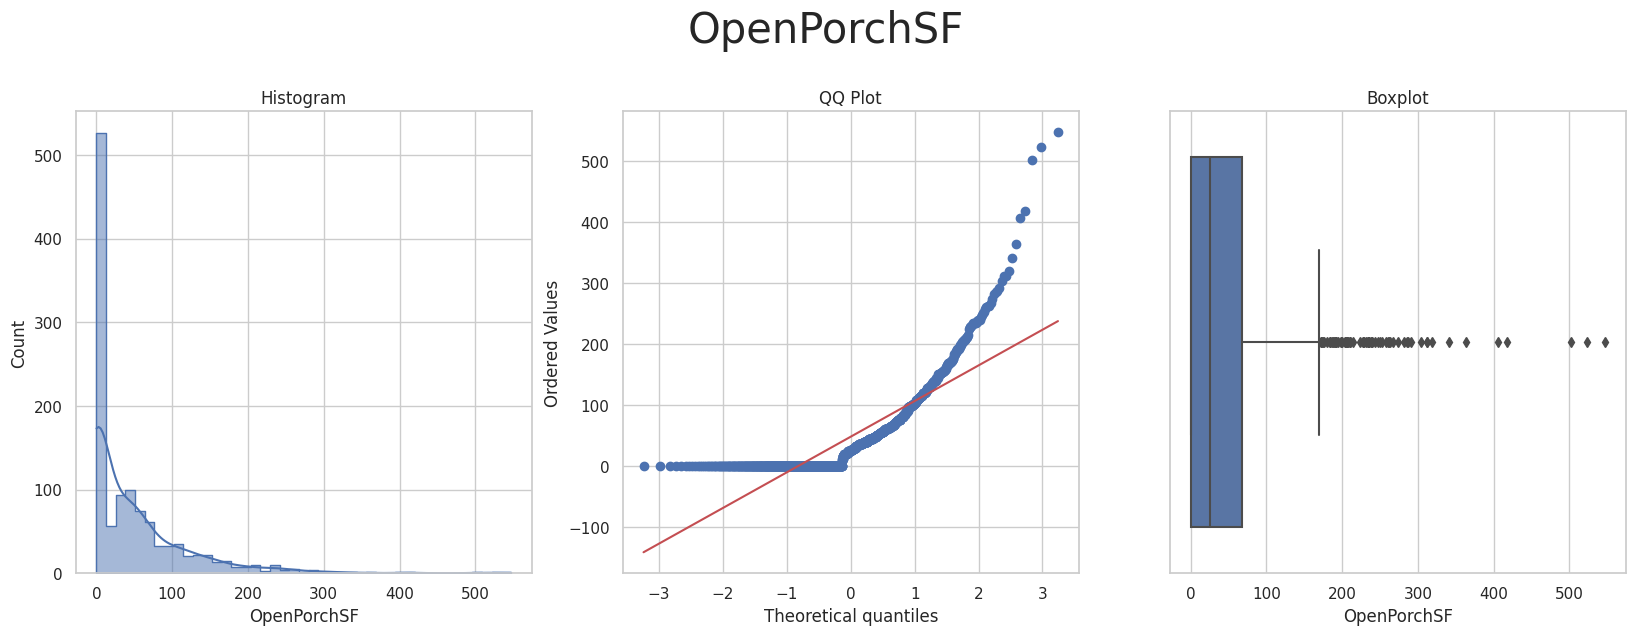

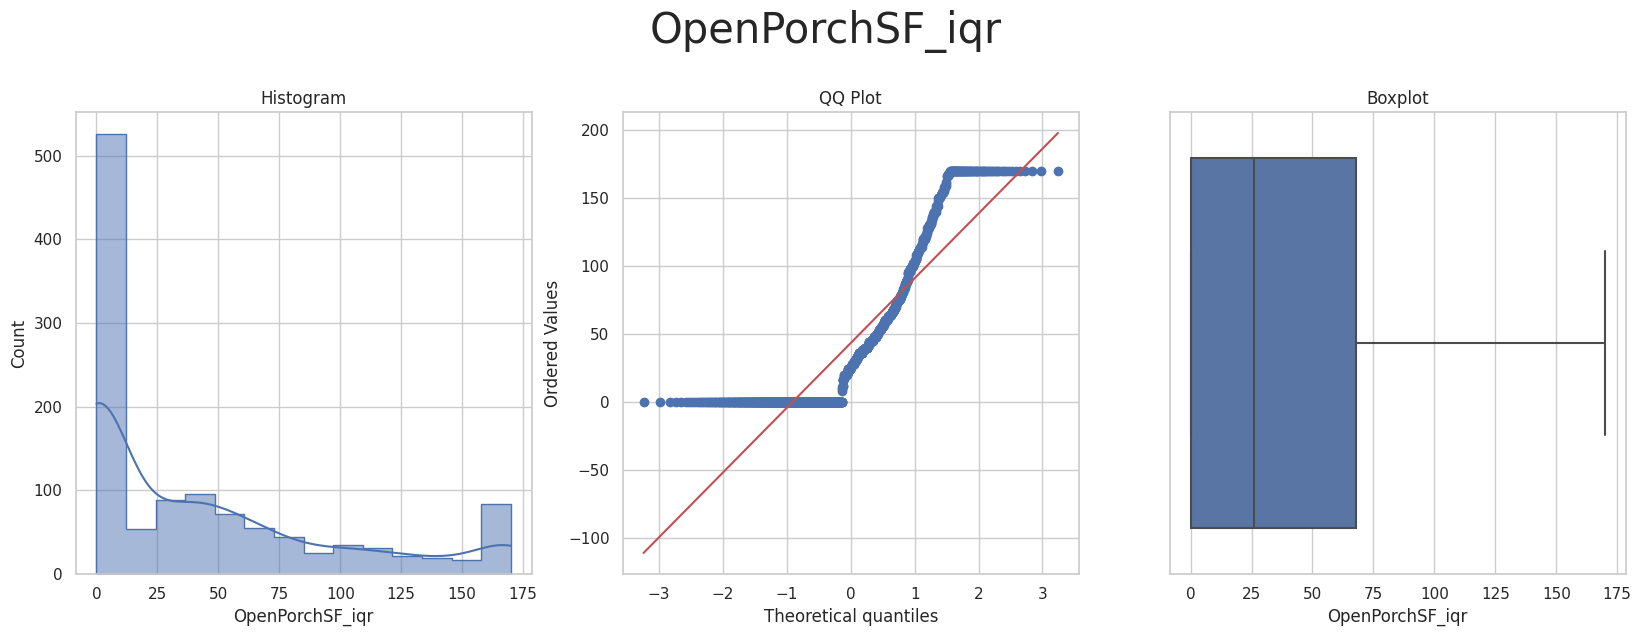



* Variable Analyzed: OverallCond
* Applied transformation: ['OverallCond_iqr'] 



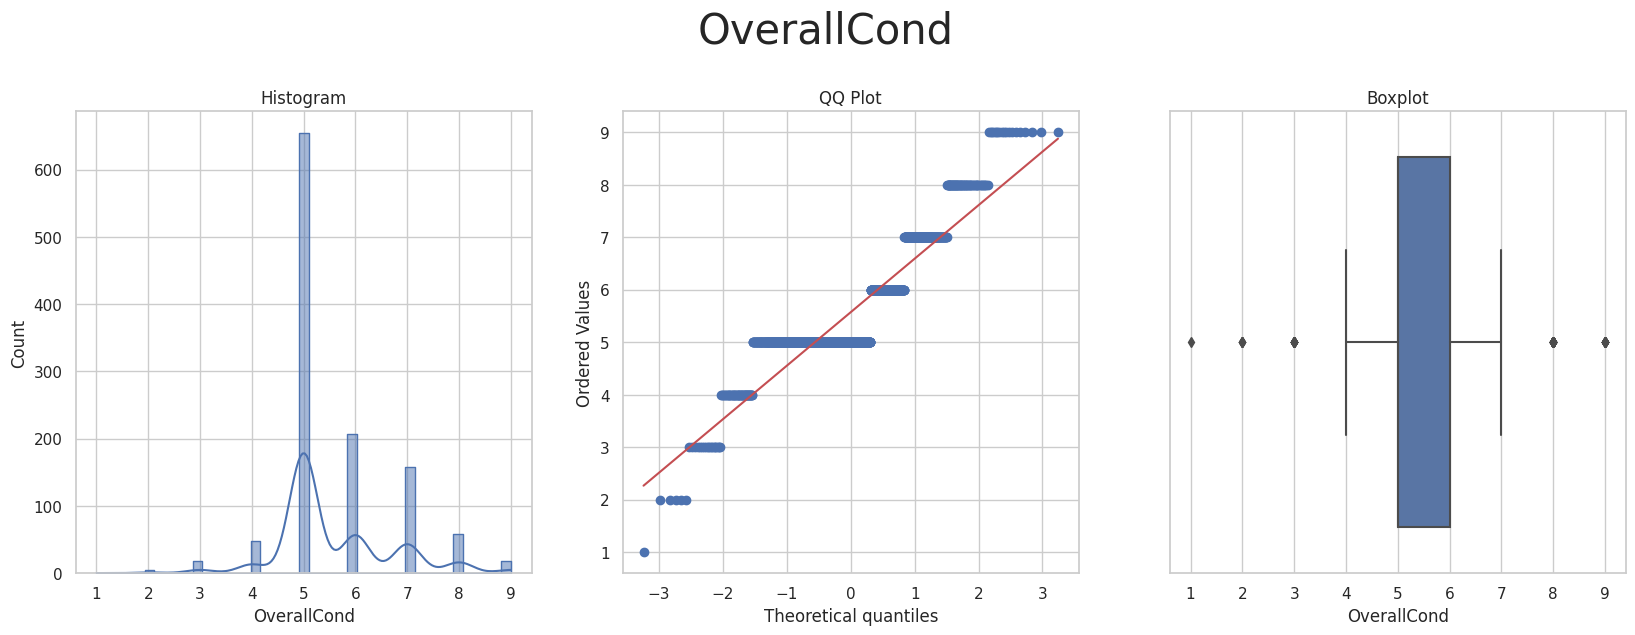

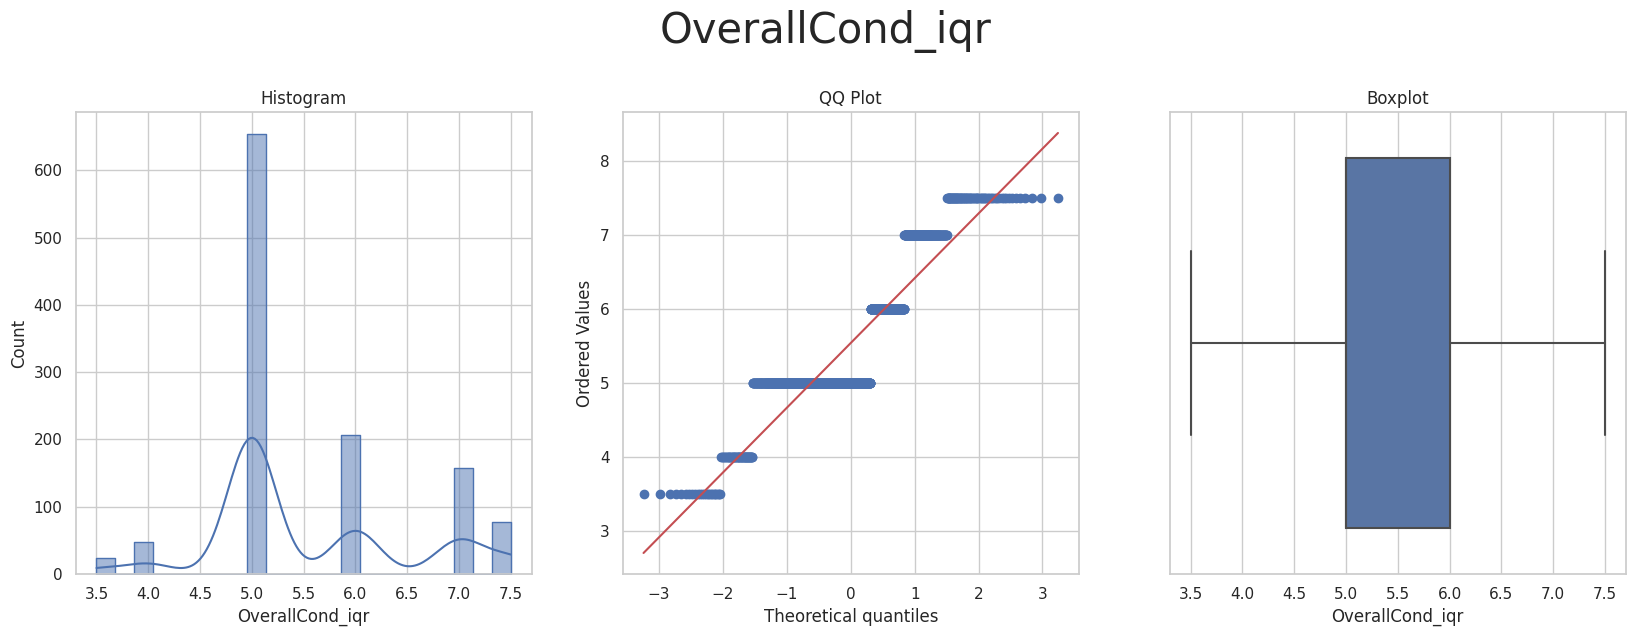



* Variable Analyzed: OverallQual
* Applied transformation: ['OverallQual_iqr'] 



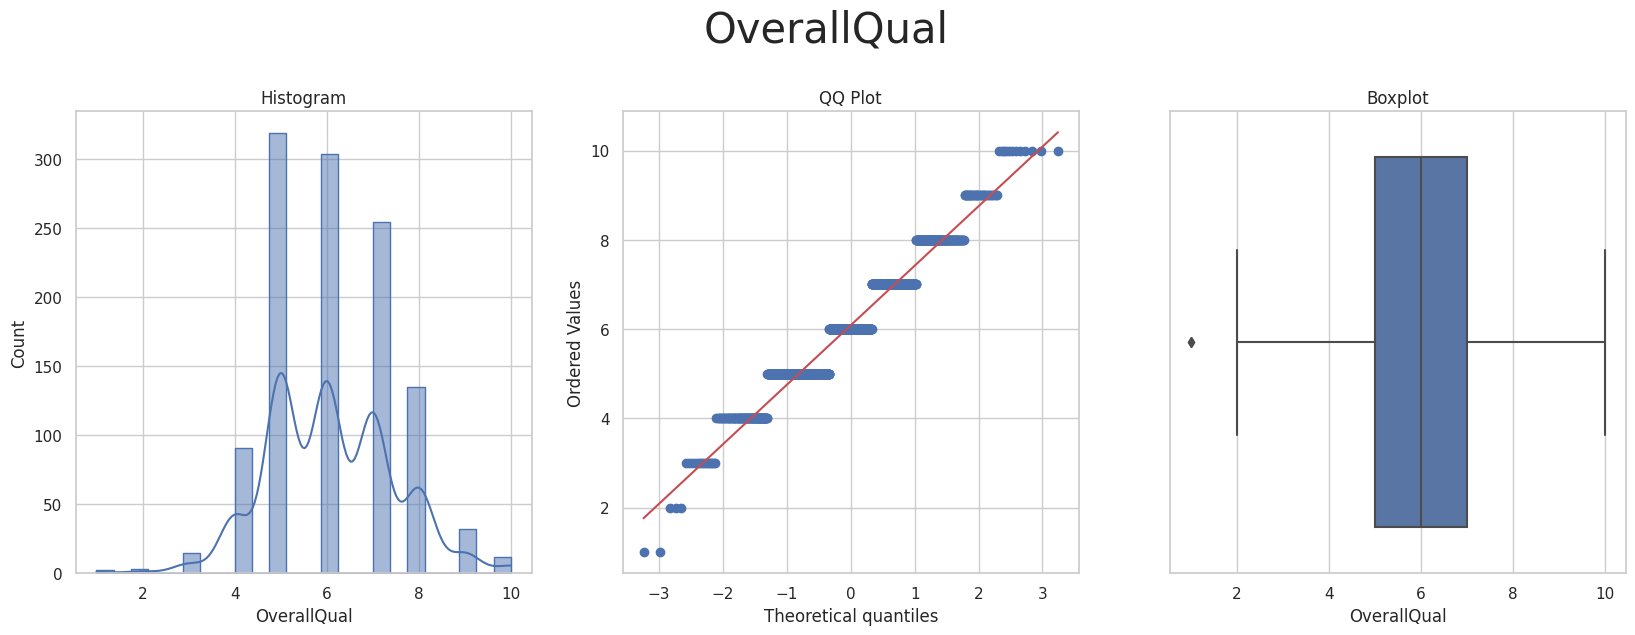

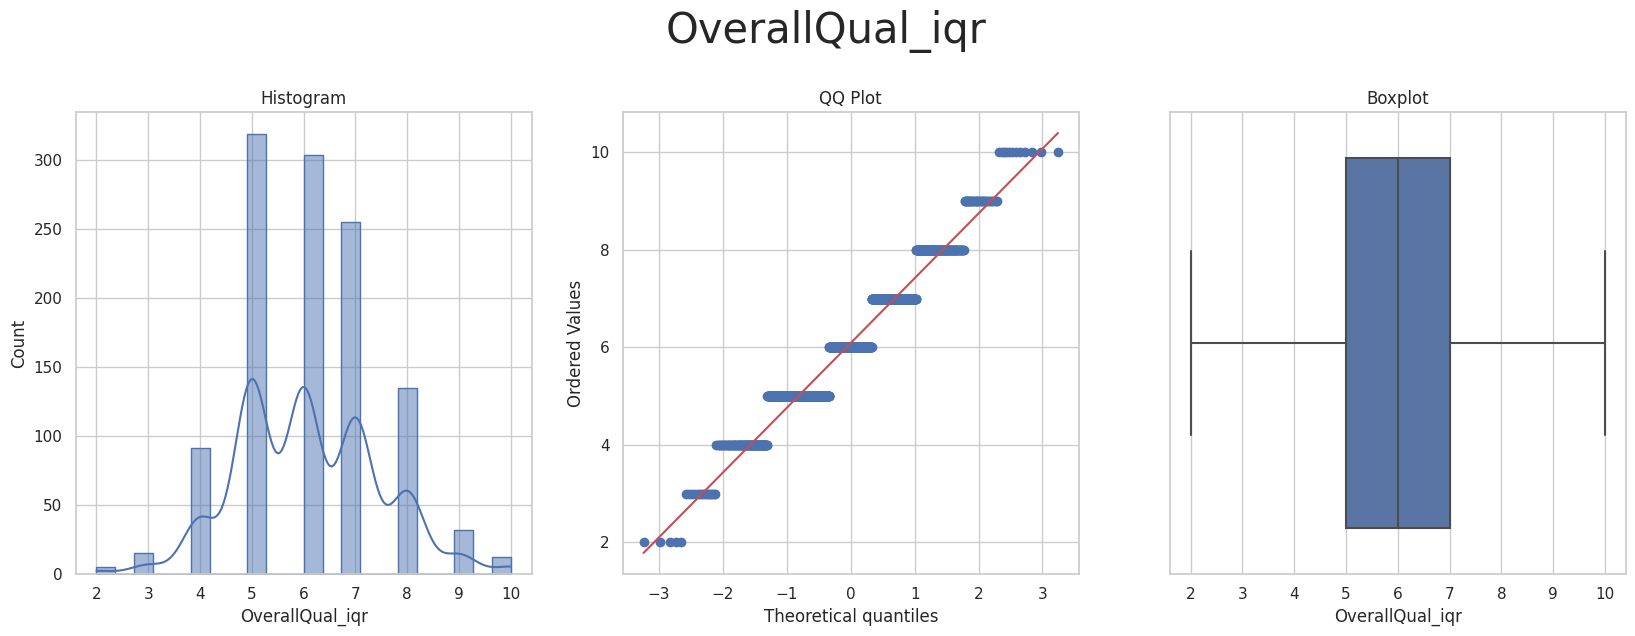



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_iqr'] 



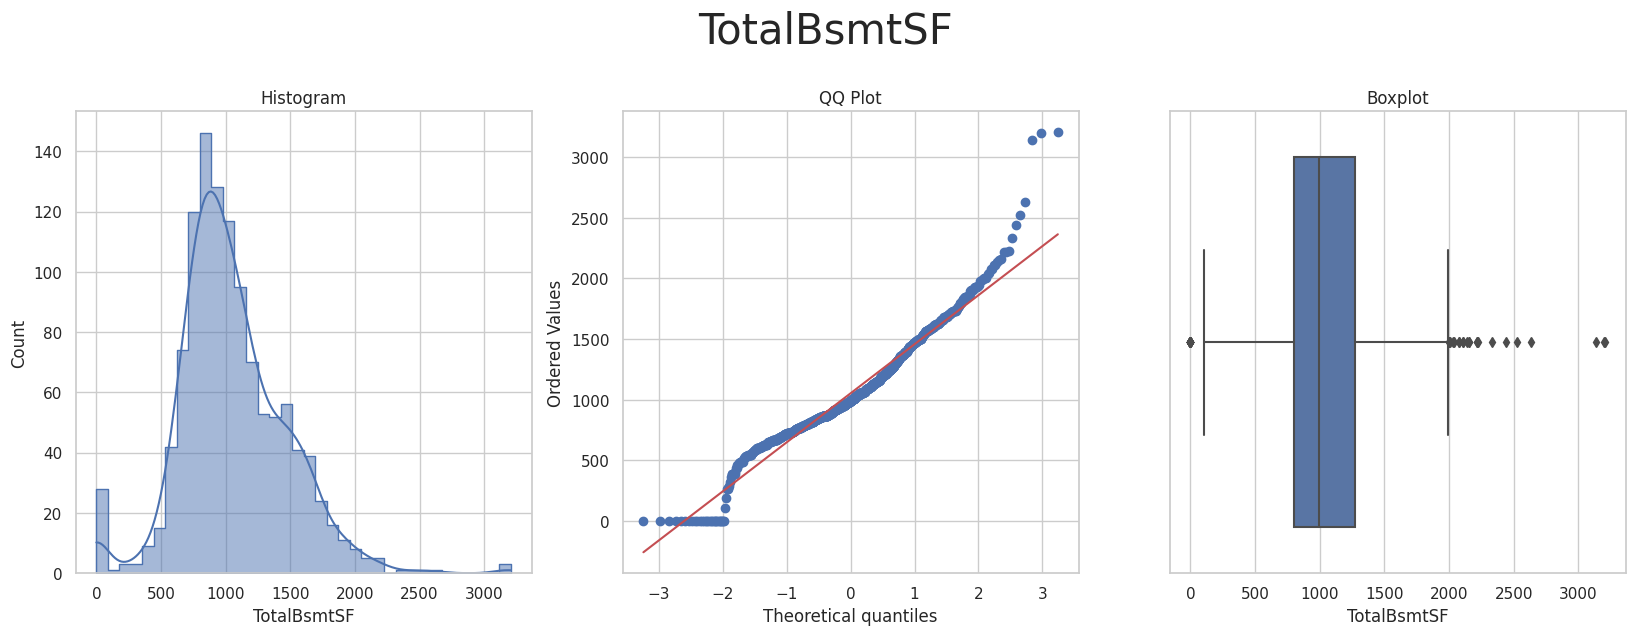

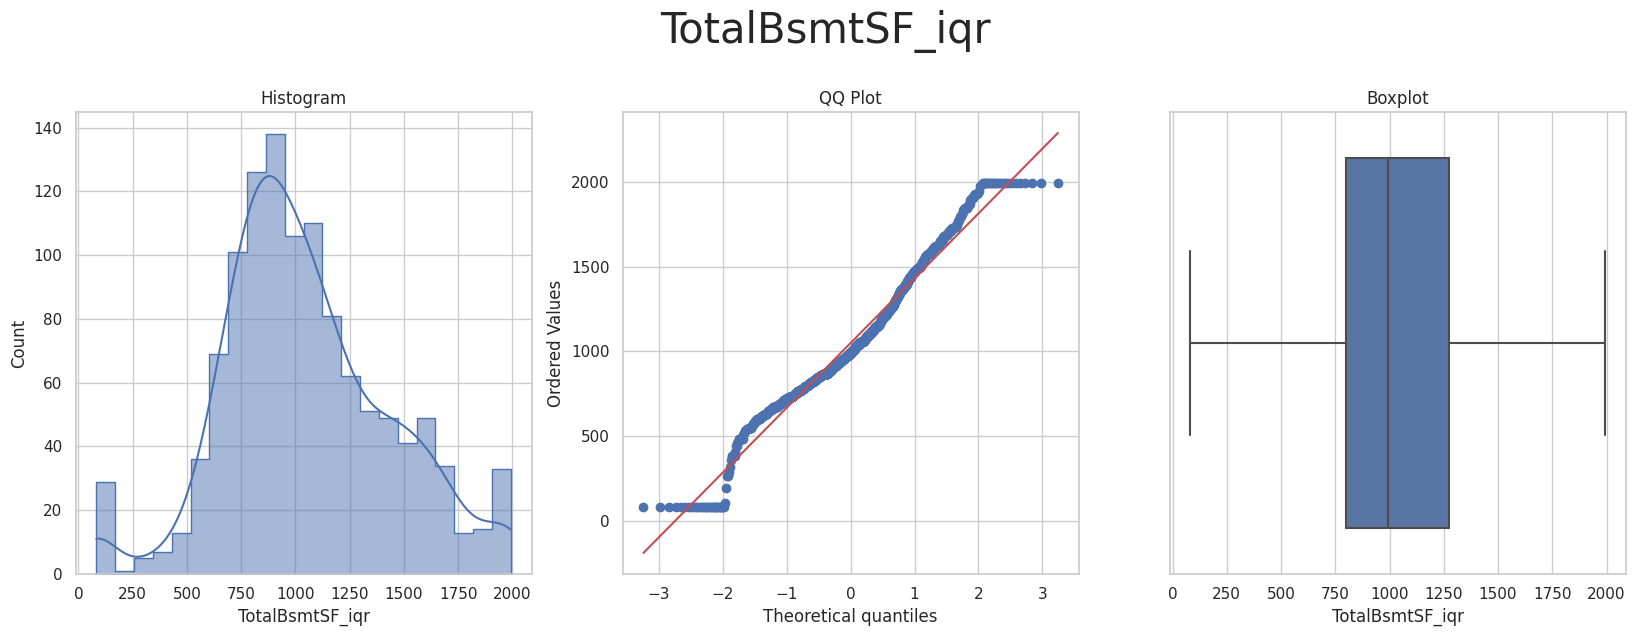



* Variable Analyzed: WoodDeckSF
* Applied transformation: ['WoodDeckSF_iqr'] 



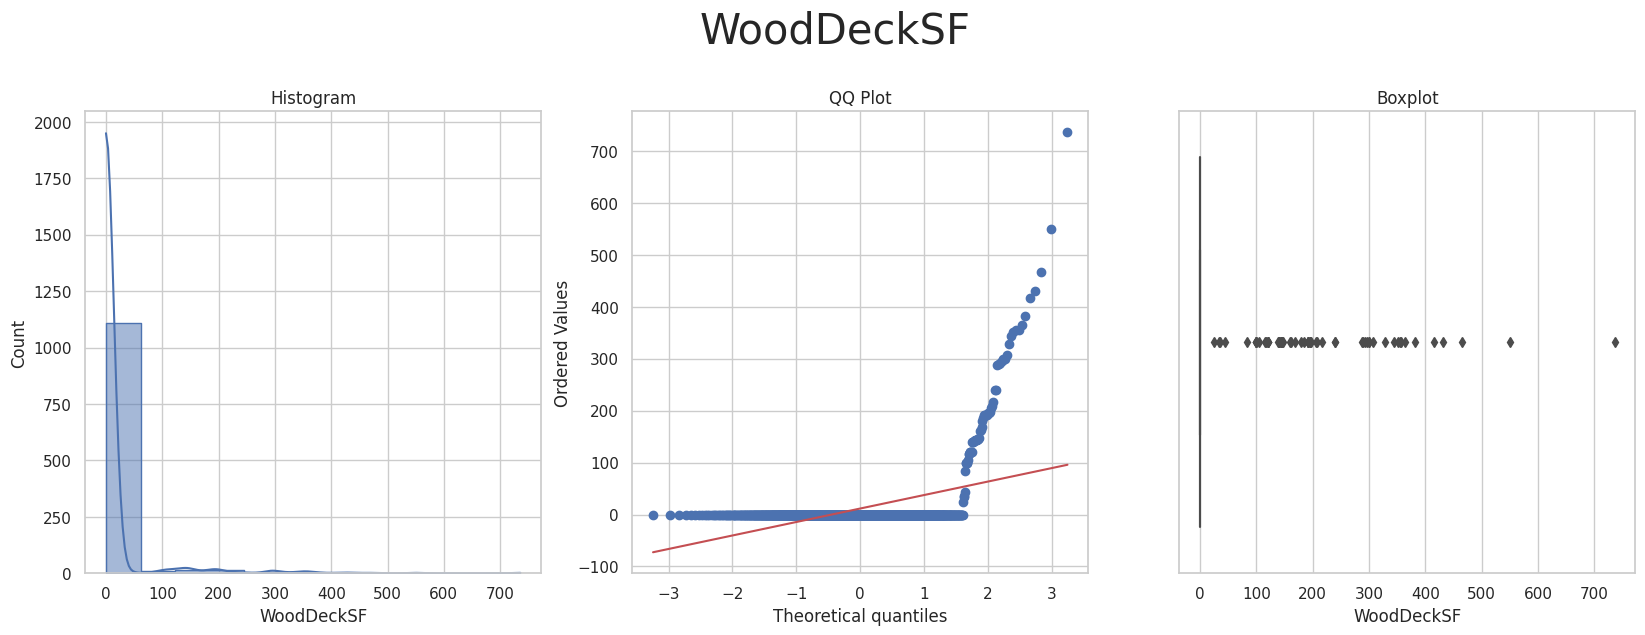

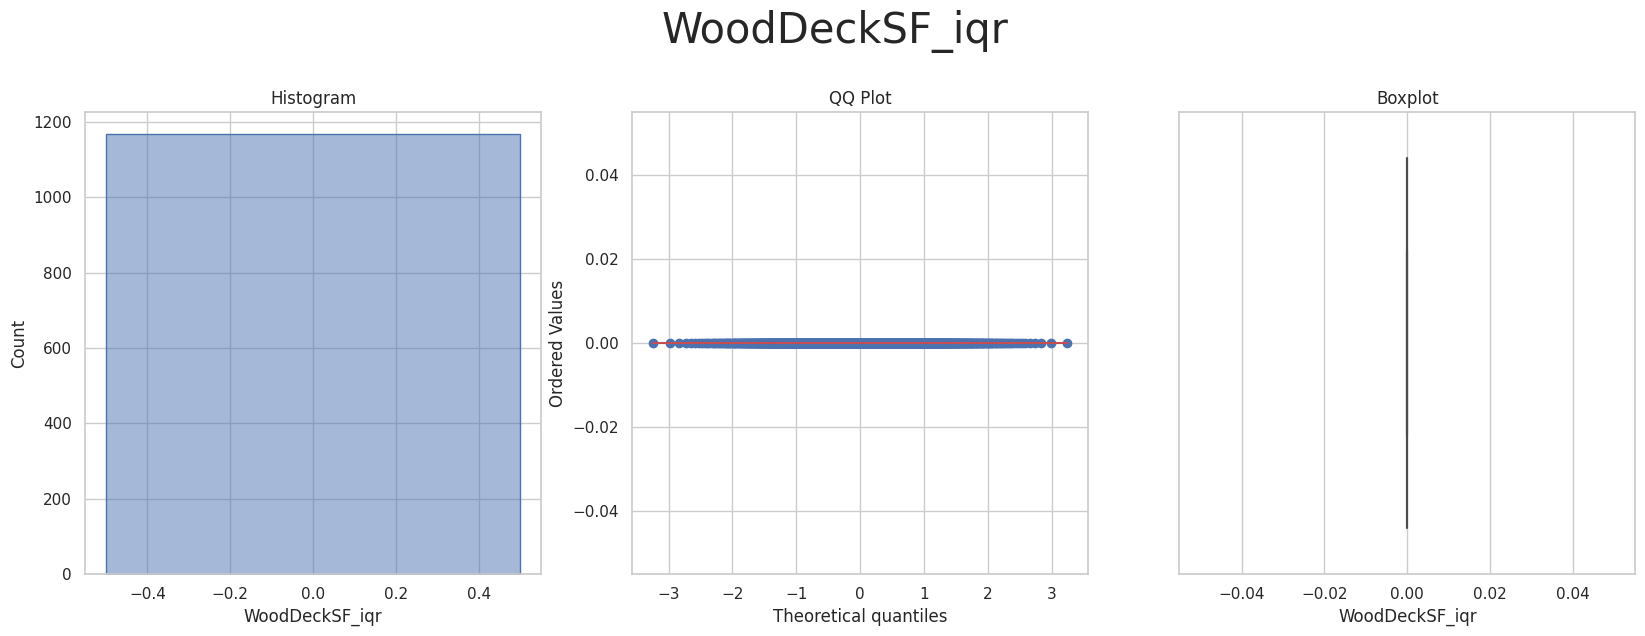



* Variable Analyzed: YearBuilt
* Applied transformation: ['YearBuilt_iqr'] 



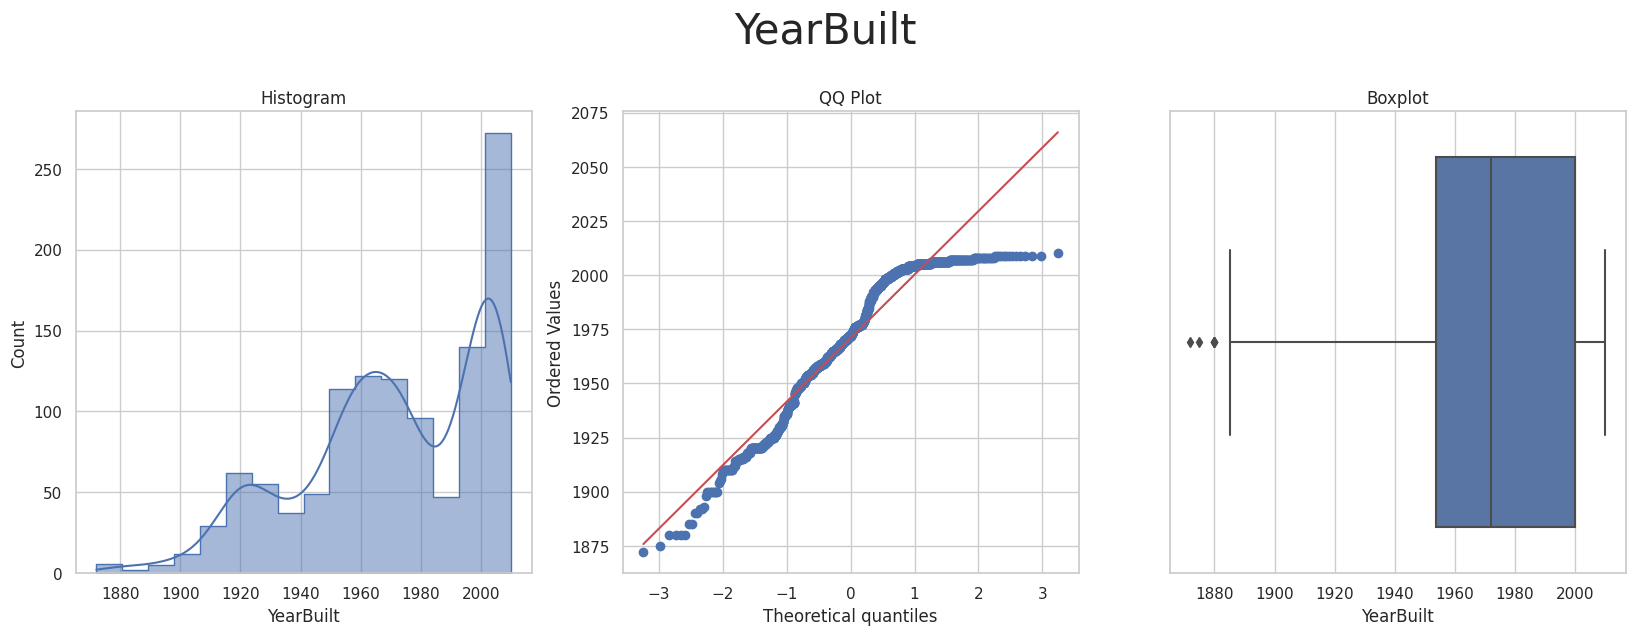

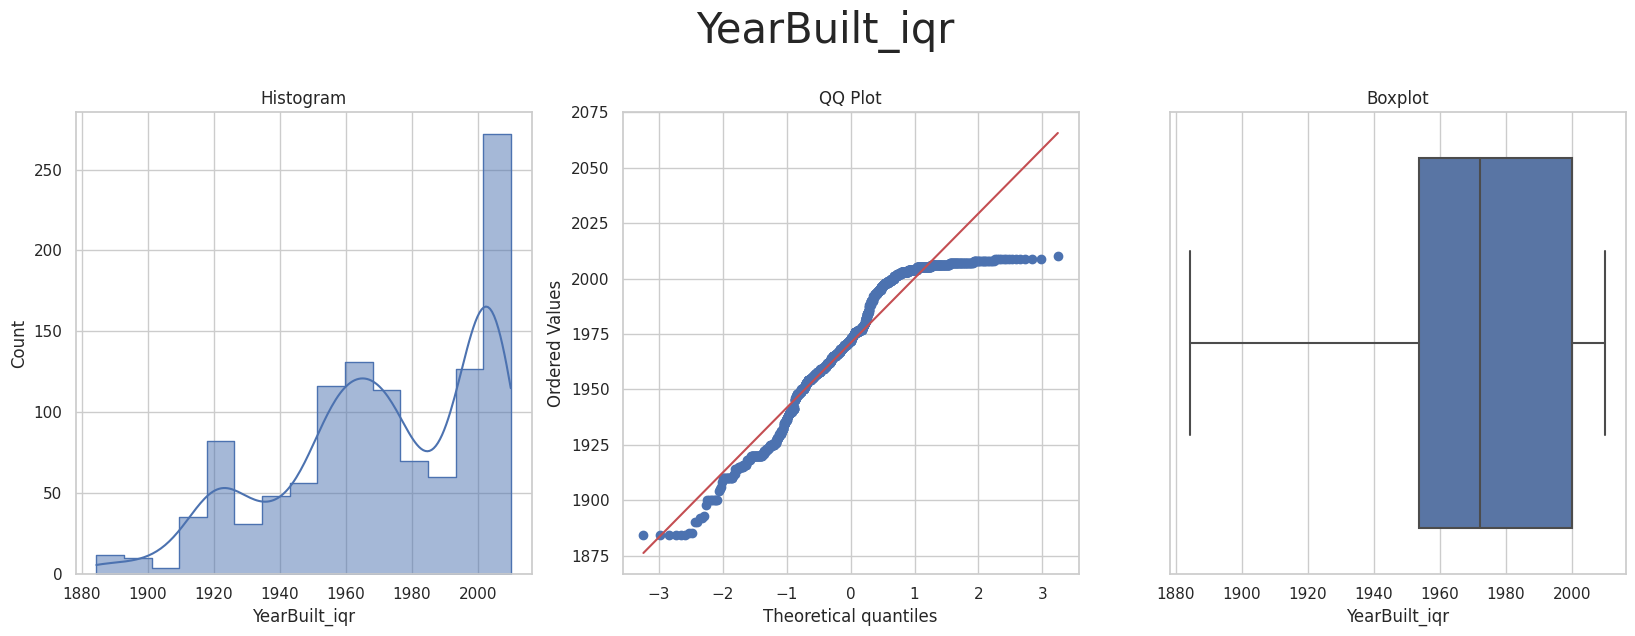



* Variable Analyzed: YearRemodAdd
* Applied transformation: ['YearRemodAdd_iqr'] 



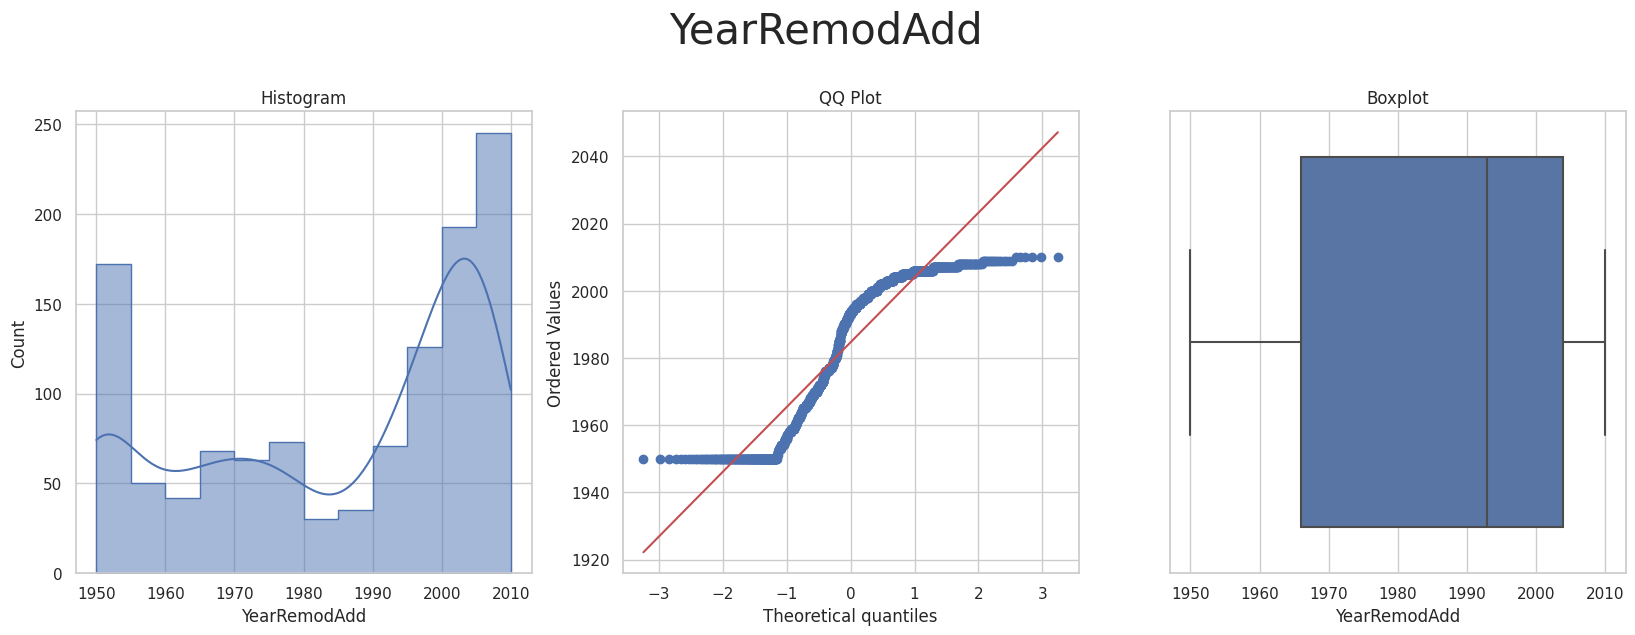

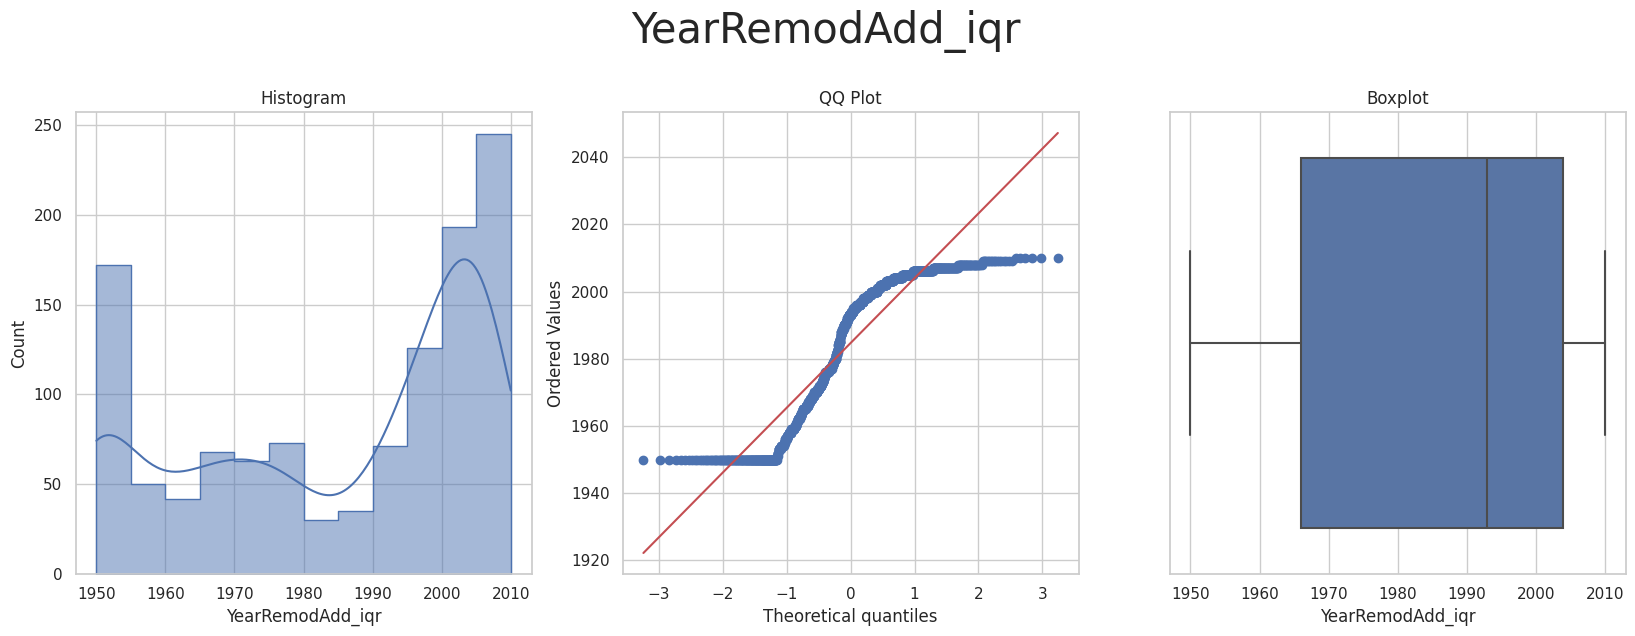

In [27]:
df_engineered = FeatureEngineeringAnalysis(df=df_engineered, analysis_type='outlier_winsorizer')

# SmartCorrelatedSelection

* We will run smart correlated selction on all of our variables apart from our target which is 'SalePrice. We will use the pearson method as our final ML model is likely to be a regression model. We can revisit this stage if our model is inefficient.

In [ ]:
smart_correlation_features = TrainSet.columns.to_list() 
smart_correlation_features.pop()
smart_correlation_features

* We create a separate dataframe with our variables

In [ ]:
df_engineered = TrainSet.copy()
df_engineered.head(3)

* We create our engineered variables and analyse which variables to drop

In [ ]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=smart_correlation_features, method="pearson", threshold=0.6,selection_method="variance")

corr_sel.fit_transform(df_engineered)
corr_sel.correlated_feature_sets_

In [ ]:
corr_sel.features_to_drop_

* It is shown that '1stFlrSF', '2ndFlrSF', 'GarageYrBlt', 'YearRemodAdd' will be dropped in the pipeline

# Next steps:

* We will add the following fetaure engineering steps to our pipeline:
    * We will apply log_e transformation to '1stFlrSF' & 'LotArea'
    * We will apply Yeo Johnson transformation to 'GrLivArea'
    * We will add a SmartCorrelatedSelection step to the pipeline


* There are no files to push to the repo in this notebook.